In [1]:
# python 3.12

In [2]:
%%capture
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn.functional import relu
from torch.utils.data import Dataset
from torchvision import models
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from tensorboardX import SummaryWriter

# Data Loading

In [3]:
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import os
from PIL import Image
import torchvision.transforms as transforms

img_size = 512  # Size of the input images
# Training transformations
common_train_transform = A.Compose([
	#A.PadIfNeeded(min_height=284, min_width=284, border_mode=0),  
	A.Resize(img_size, img_size),  
	A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit= 20, p =0.5),
	A.CenterCrop(img_size, img_size, p=0.5),
	#A.Normalize(mean=[0.5], std=[0.5]),  # Normalize to [0,1] range
	#ToTensorV2(),
])

# Validation transformations
common_val_transform = A.Compose([
	#A.PadIfNeeded(min_height=284, min_width=284, border_mode=0),
	A.Resize(img_size, img_size),
	#A.Normalize(mean=[0.5], std=[0.5]),
	#ToTensorV2(),
])

# Normalization for images
transform_img = A.Compose([
	#A.Normalize(mean=[58.42], std=[51.01]),
	A.Normalize(mean=[0.5], std=[0.5]),
	ToTensorV2(),
])

# Transform mask: Convert to binary mask and tensor
transform_mask = A.Compose([
	#A.Lambda(image=lambda x: (x > 0).float()),  
	ToTensorV2(),
])


 # This dataset loader will be used for experiment with single image based (MR1 or MR2) model , where model is encoder(narrow) + fc regression model   
class ImageLoader_Dataset(Dataset):
	def __init__(
		self,
		root_dir="../../data/washu_all_img",
		response_dir="../../data/PAT_imaging_record.xlsx",
		phase="train",
		img_transform=None,
		k_fold=5,
		fold=0,
	):
		self.root_dir = root_dir
		self.phase = phase
		self.img_transform = img_transform

		# Step 1: Read Excel sheet
		df = pd.read_excel(response_dir, sheet_name="ROI STATS V3")
		df = df.dropna(subset=["Patient ID", "Side", "GT"])
		df["Patient ID"] = df["Patient ID"].astype(int).astype(str).str.strip()
		df["Side"] = df["Side"].astype(str).str.strip()
		df["GT"] = pd.to_numeric(df["GT"], errors="coerce").astype("Int64")
		df = df.dropna(subset=["GT"])
		df["GT"] = df["GT"].astype(int)

		label_map = {
			("p" + row["Patient ID"], row["Side"]): row["GT"]
			for _, row in df.iterrows()
		}

		# Step 2: Get all patient IDs and apply k-fold
		all_patient_ids = sorted([
			d for d in os.listdir(root_dir)
			if os.path.isdir(os.path.join(root_dir, d))
		])

		# kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
		# splits = list(kf.split(all_patient_ids))
		# train_idx, val_idx = splits[fold]

		if phase == 'train':
			selected_patient_ids = all_patient_ids # [all_patient_ids[i] for i in train_idx]
		else:
			selected_patient_ids = all_patient_ids # [all_patient_ids[i] for i in val_idx]


		# Step 3: Gather all samples
		all_samples = []
		for patient_id in selected_patient_ids:
			patient_path = os.path.join(root_dir, patient_id)
			for side in os.listdir(patient_path):
				side_path = os.path.join(patient_path, side)
				if not os.path.isdir(side_path):
					continue

				key = (patient_id, side)
				if key not in label_map:
					continue

				label = label_map[key]
				label = 1 if label == 0 else 0  # Optional: relabel if needed

				for fname in os.listdir(side_path):
					if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
						full_path = os.path.join(side_path, fname)
						if os.path.exists(full_path):
							all_samples.append((full_path, label))

		self.data = all_samples
			
	def __len__(self):
		return len(self.data)
	
	def __getitem__(self, index):
		image_path, response = self.data[index]

		# Load image and mask as grayscale NumPy arrays
		image = np.array(Image.open(image_path).convert('L'))

		# Apply the corresponding transformations
		if self.phase == 'train':
			transformed = common_train_transform(image=image)
		else:
			transformed = common_val_transform(image=image)

		slice_image = transformed['image']
		# Apply additional transformations if provided
		if self.img_transform:
			slice_image = self.img_transform(image=slice_image)['image'].to(torch.float32)
			slice_image =  slice_image #transforms.functional.normalize(slice_image, mean=34.80, std= 42.51)

		return slice_image, torch.tensor(response, dtype=torch.float32), image_path

c:\Users\mdiqb\anaconda3\envs\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mdiqb\anaconda3\envs\py312\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\mdiqb\anaconda3\envs\py312\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [4]:
from torch.utils.data import DataLoader

In [5]:
testDataset =  ImageLoader_Dataset(phase = 'test', img_transform= transform_img)
batch_size = 1
num_workers = 0
drop_last = False 
test_dataloader = DataLoader(
            testDataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            drop_last= drop_last,
            #persistent_workers=True,
        )

Feature batch shape: torch.Size([1, 1, 512, 512])
Masks batch shape: torch.Size([1])


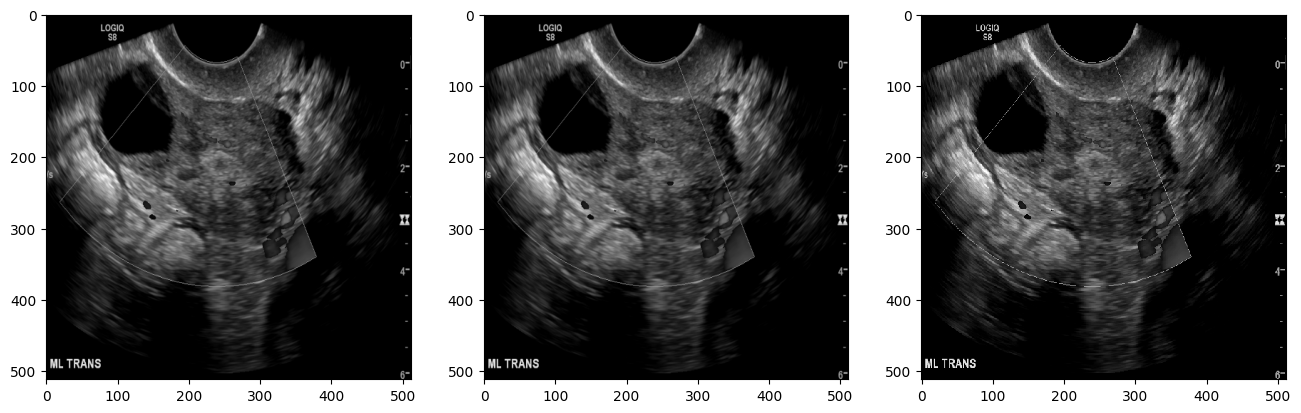

In [6]:
train_features, train_masks, image_path = next(iter(test_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Masks batch shape: {train_masks.size()}")

img = train_features[0].squeeze()
# mask = train_masks[0].squeeze()
# img_mask = np.ma.masked_where(mask == 0, mask)

fig, ax = plt.subplots(1,3,figsize = (16,12))

ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(img, cmap = 'gray')
ax[2].imshow(img, cmap = 'gray', interpolation = 'none')
# ax[2].imshow(img_mask, cmap = 'jet', interpolation = 'none', alpha = 0.7)

In [7]:
# %%capture
# !pip install -U segmentation-models-pytorch
# !pip install tqdm

In [8]:
import segmentation_models_pytorch as smp
from tqdm import tqdm

In [9]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model_path = "../../checkpoints/deeplabv3/model_20250522_125038_49"
print("Best model saved to: ", model_path)
model.load_state_dict(torch.load(model_path))  
model.to(device)
model.eval()

Using device: cuda
Best model saved to:  ../../checkpoints/deeplabv3/model_20250522_125038_49


DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

## Visualizing results

In [11]:
validation_dataset = testDataset 

In [12]:
with torch.no_grad():
    for i in tqdm(range(len(validation_dataset))):
        image, mask, image_path = validation_dataset[i]
        image = image.unsqueeze(0).to(device)
        prediction = model(image)
        predicted_mask = torch.argmax(prediction, dim=1).squeeze().cpu().numpy()
        predicted_mask = (predicted_mask > 0).astype(np.uint8)

        image = image.squeeze().cpu().numpy()

        save_path_image = image_path.replace("washu_all_img", "washu_all_img/Images")
        save_path_mask = image_path.replace("washu_all_img", "washu_all_img/Masks")
        os.makedirs(os.path.dirname(save_path_image), exist_ok=True)
        os.makedirs(os.path.dirname(save_path_mask), exist_ok=True)
        Image.fromarray((image * 255).astype(np.uint8)).save(save_path_image)  
        Image.fromarray((predicted_mask * 255).astype(np.uint8)).save(save_path_mask)
        print(f"Saved image to {save_path_image} and mask to {save_path_mask}")
        

  1%|          | 7/734 [00:00<00:25, 28.83it/s]

Saved image to ../../data/washu_all_img/Images\p10\R\1.jpg and mask to ../../data/washu_all_img/Masks\p10\R\1.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\10.jpg and mask to ../../data/washu_all_img/Masks\p10\R\10.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\106.jpg and mask to ../../data/washu_all_img/Masks\p10\R\106.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\11.jpg and mask to ../../data/washu_all_img/Masks\p10\R\11.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\118.jpg and mask to ../../data/washu_all_img/Masks\p10\R\118.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\119.jpg and mask to ../../data/washu_all_img/Masks\p10\R\119.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\12.jpg and mask to ../../data/washu_all_img/Masks\p10\R\12.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\13.jpg and mask to ../../data/washu_all_img/Masks\p10\R\13.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\14.jpg and mask

  3%|▎         | 21/734 [00:00<00:14, 49.29it/s]

Saved image to ../../data/washu_all_img/Images\p10\R\3.jpg and mask to ../../data/washu_all_img/Masks\p10\R\3.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\365.jpg and mask to ../../data/washu_all_img/Masks\p10\R\365.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\398.jpg and mask to ../../data/washu_all_img/Masks\p10\R\398.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\409.jpg and mask to ../../data/washu_all_img/Masks\p10\R\409.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\411.jpg and mask to ../../data/washu_all_img/Masks\p10\R\411.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\412.jpg and mask to ../../data/washu_all_img/Masks\p10\R\412.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\413.jpg and mask to ../../data/washu_all_img/Masks\p10\R\413.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\414.jpg and mask to ../../data/washu_all_img/Masks\p10\R\414.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\415.jpg

  5%|▍         | 34/734 [00:00<00:12, 56.03it/s]

Saved image to ../../data/washu_all_img/Images\p10\R\428.jpg and mask to ../../data/washu_all_img/Masks\p10\R\428.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\429.jpg and mask to ../../data/washu_all_img/Masks\p10\R\429.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\43.jpg and mask to ../../data/washu_all_img/Masks\p10\R\43.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\440.jpg and mask to ../../data/washu_all_img/Masks\p10\R\440.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\5.jpg and mask to ../../data/washu_all_img/Masks\p10\R\5.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\52.jpg and mask to ../../data/washu_all_img/Masks\p10\R\52.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\59.jpg and mask to ../../data/washu_all_img/Masks\p10\R\59.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\6.jpg and mask to ../../data/washu_all_img/Masks\p10\R\6.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\61.jpg and mask t

  7%|▋         | 48/734 [00:00<00:11, 60.59it/s]

Saved image to ../../data/washu_all_img/Images\p10\R\67.jpg and mask to ../../data/washu_all_img/Masks\p10\R\67.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\68.jpg and mask to ../../data/washu_all_img/Masks\p10\R\68.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\69.jpg and mask to ../../data/washu_all_img/Masks\p10\R\69.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\7.jpg and mask to ../../data/washu_all_img/Masks\p10\R\7.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\70.jpg and mask to ../../data/washu_all_img/Masks\p10\R\70.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\71.jpg and mask to ../../data/washu_all_img/Masks\p10\R\71.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\72.jpg and mask to ../../data/washu_all_img/Masks\p10\R\72.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\73.jpg and mask to ../../data/washu_all_img/Masks\p10\R\73.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\74.jpg and mask to ..

  8%|▊         | 62/734 [00:01<00:10, 63.30it/s]

Saved image to ../../data/washu_all_img/Images\p10\R\8.jpg and mask to ../../data/washu_all_img/Masks\p10\R\8.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\80.jpg and mask to ../../data/washu_all_img/Masks\p10\R\80.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\81.jpg and mask to ../../data/washu_all_img/Masks\p10\R\81.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\82.jpg and mask to ../../data/washu_all_img/Masks\p10\R\82.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\83.jpg and mask to ../../data/washu_all_img/Masks\p10\R\83.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\84.jpg and mask to ../../data/washu_all_img/Masks\p10\R\84.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\85.jpg and mask to ../../data/washu_all_img/Masks\p10\R\85.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\86.jpg and mask to ../../data/washu_all_img/Masks\p10\R\86.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\87.jpg and mask to ..

 10%|█         | 76/734 [00:01<00:12, 54.58it/s]

Saved image to ../../data/washu_all_img/Images\p10\R\95.jpg and mask to ../../data/washu_all_img/Masks\p10\R\95.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\96.jpg and mask to ../../data/washu_all_img/Masks\p10\R\96.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\97.jpg and mask to ../../data/washu_all_img/Masks\p10\R\97.jpg
Saved image to ../../data/washu_all_img/Images\p10\R\98.jpg and mask to ../../data/washu_all_img/Masks\p10\R\98.jpg
Saved image to ../../data/washu_all_img/Images\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-4608-5y6zif.png and mask to ../../data/washu_all_img/Masks\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-4608-5y6zif.png
Saved image to ../../data/washu_all_img/Images\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-4864-6e50px.png and mask to ../../data/washu_all_img/Masks\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-4864-6e50px.png
Saved image to ../../data/washu_all_img/Images\p101\L\1.2.840.114350.2.456.2.798

 11%|█         | 82/734 [00:01<00:14, 44.68it/s]

Saved image to ../../data/washu_all_img/Images\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-5632-7qiwxs (2).png and mask to ../../data/washu_all_img/Masks\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-5632-7qiwxs (2).png
Saved image to ../../data/washu_all_img/Images\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-5632-7qiwxs.png and mask to ../../data/washu_all_img/Masks\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-5632-7qiwxs.png
Saved image to ../../data/washu_all_img/Images\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-5888-87kjc0.png and mask to ../../data/washu_all_img/Masks\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-5888-87kjc0.png
Saved image to ../../data/washu_all_img/Images\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-6144-88o4ir.png and mask to ../../data/washu_all_img/Masks\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-6144-88o4ir.png
Saved image to ../../data/washu_all_img/Images\p101\L\1.2.840.114350.2.456.2.798

 12%|█▏        | 87/734 [00:01<00:16, 40.25it/s]

Saved image to ../../data/washu_all_img/Images\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-7168-18rklq6.png and mask to ../../data/washu_all_img/Masks\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-7168-18rklq6.png
Saved image to ../../data/washu_all_img/Images\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-7424-19l9hrp.png and mask to ../../data/washu_all_img/Masks\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-7424-19l9hrp.png
Saved image to ../../data/washu_all_img/Images\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-7936-1b4spp8.png and mask to ../../data/washu_all_img/Masks\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-7936-1b4spp8.png
Saved image to ../../data/washu_all_img/Images\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-8192-1bz1ec4.png and mask to ../../data/washu_all_img/Masks\p101\L\1.2.840.114350.2.456.2.798268.2.519992526.1-1-8192-1bz1ec4.png
Saved image to ../../data/washu_all_img/Images\p101\L\1.2.840.114350.2.456.2.798

 13%|█▎        | 92/734 [00:01<00:17, 35.86it/s]

Saved image to ../../data/washu_all_img/Images\p101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-3328-1qsi68c_right.png and mask to ../../data/washu_all_img/Masks\p101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-3328-1qsi68c_right.png
Saved image to ../../data/washu_all_img/Images\p101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-3584-1roe8nb.png and mask to ../../data/washu_all_img/Masks\p101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-3584-1roe8nb.png
Saved image to ../../data/washu_all_img/Images\p101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-3840-1s38ooo.png and mask to ../../data/washu_all_img/Masks\p101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-3840-1s38ooo.png
Saved image to ../../data/washu_all_img/Images\p101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-4096-1tl4iu3.png and mask to ../../data/washu_all_img/Masks\p101\R\1.2.840.114350.2.456.2.798268.2.519992526.1-1-4096-1tl4iu3.png
Saved image to ../../data/washu_all_img/Images\p101\R\1.2.840.114350

 14%|█▎        | 100/734 [00:02<00:21, 30.13it/s]

Saved image to ../../data/washu_all_img/Images\p102\L\1.2.840.114350.2.456.2.798268.2.515950085.1-1-2560-1myqdg9.png and mask to ../../data/washu_all_img/Masks\p102\L\1.2.840.114350.2.456.2.798268.2.515950085.1-1-2560-1myqdg9.png
Saved image to ../../data/washu_all_img/Images\p102\L\1.2.840.114350.2.456.2.798268.2.515950085.1-1-3328-1rrnnjy.png and mask to ../../data/washu_all_img/Masks\p102\L\1.2.840.114350.2.456.2.798268.2.515950085.1-1-3328-1rrnnjy.png
Saved image to ../../data/washu_all_img/Images\p102\L\1.2.840.114350.2.456.2.798268.2.515950085.1-1-4096-kqeh7u.png and mask to ../../data/washu_all_img/Masks\p102\L\1.2.840.114350.2.456.2.798268.2.515950085.1-1-4096-kqeh7u.png
Saved image to ../../data/washu_all_img/Images\p102\L\1.2.840.114350.2.456.2.798268.2.515950085.1-1-4608-lmajnf.png and mask to ../../data/washu_all_img/Masks\p102\L\1.2.840.114350.2.456.2.798268.2.515950085.1-1-4608-lmajnf.png
Saved image to ../../data/washu_all_img/Images\p103\L\1.2.840.114350.2.456.2.798268.

 14%|█▍        | 104/734 [00:02<00:21, 29.71it/s]

Saved image to ../../data/washu_all_img/Images\p103\L\1.2.840.114350.2.456.2.798268.2.527183362.1-1-8960-1wuf3ao.png and mask to ../../data/washu_all_img/Masks\p103\L\1.2.840.114350.2.456.2.798268.2.527183362.1-1-8960-1wuf3ao.png
Saved image to ../../data/washu_all_img/Images\p103\L\1.2.840.114350.2.456.2.798268.2.527183362.1-1-9472-b1gv6c_left.png and mask to ../../data/washu_all_img/Masks\p103\L\1.2.840.114350.2.456.2.798268.2.527183362.1-1-9472-b1gv6c_left.png
Saved image to ../../data/washu_all_img/Images\p103\R\1.2.840.114350.2.456.2.798268.2.527183362.1-1-3328-mvbnri (1).png and mask to ../../data/washu_all_img/Masks\p103\R\1.2.840.114350.2.456.2.798268.2.527183362.1-1-3328-mvbnri (1).png
Saved image to ../../data/washu_all_img/Images\p103\R\1.2.840.114350.2.456.2.798268.2.527183362.1-1-3328-mvbnri.png and mask to ../../data/washu_all_img/Masks\p103\R\1.2.840.114350.2.456.2.798268.2.527183362.1-1-3328-mvbnri.png
Saved image to ../../data/washu_all_img/Images\p103\R\1.2.840.114350

 15%|█▌        | 111/734 [00:02<00:22, 28.22it/s]

Saved image to ../../data/washu_all_img/Images\p104\L\1.2.840.114350.2.456.2.798268.2.77101887.1-1-7168-31flsb_left.png and mask to ../../data/washu_all_img/Masks\p104\L\1.2.840.114350.2.456.2.798268.2.77101887.1-1-7168-31flsb_left.png
Saved image to ../../data/washu_all_img/Images\p104\R\1.2.840.114350.2.456.2.798268.2.77101887.1-1-4352-1kztoct_right.png and mask to ../../data/washu_all_img/Masks\p104\R\1.2.840.114350.2.456.2.798268.2.77101887.1-1-4352-1kztoct_right.png
Saved image to ../../data/washu_all_img/Images\p104\R\1.2.840.114350.2.456.2.798268.2.77101887.1-1-5376-1nbeejt_right.png and mask to ../../data/washu_all_img/Masks\p104\R\1.2.840.114350.2.456.2.798268.2.77101887.1-1-5376-1nbeejt_right.png
Saved image to ../../data/washu_all_img/Images\p107\L\1.2.840.113619.2.323.963336588689.1628101232.6-1-1792-aoifdh.png and mask to ../../data/washu_all_img/Masks\p107\L\1.2.840.113619.2.323.963336588689.1628101232.6-1-1792-aoifdh.png
Saved image to ../../data/washu_all_img/Images\p10

 16%|█▌        | 119/734 [00:02<00:20, 30.12it/s]

Saved image to ../../data/washu_all_img/Images\p107\L\1.2.840.113619.2.323.963336588689.1628101232.6-1-3072-b5jesa.png and mask to ../../data/washu_all_img/Masks\p107\L\1.2.840.113619.2.323.963336588689.1628101232.6-1-3072-b5jesa.png
Saved image to ../../data/washu_all_img/Images\p107\L\1.2.840.113619.2.323.963336588689.1628101232.6-1-3840-bkxnf2.png and mask to ../../data/washu_all_img/Masks\p107\L\1.2.840.113619.2.323.963336588689.1628101232.6-1-3840-bkxnf2.png
Saved image to ../../data/washu_all_img/Images\p108\L\1.2.840.113619.2.323.963336588689.1628187206.6-1-3840-1a2rz55.png and mask to ../../data/washu_all_img/Masks\p108\L\1.2.840.113619.2.323.963336588689.1628187206.6-1-3840-1a2rz55.png
Saved image to ../../data/washu_all_img/Images\p108\L\1.2.840.113619.2.323.963336588689.1628187206.6-1-4096-1a37atu.png and mask to ../../data/washu_all_img/Masks\p108\L\1.2.840.113619.2.323.963336588689.1628187206.6-1-4096-1a37atu.png
Saved image to ../../data/washu_all_img/Images\p108\L\1.2.84

 17%|█▋        | 123/734 [00:03<00:19, 30.94it/s]

Saved image to ../../data/washu_all_img/Images\p108\R\1.2.840.113619.2.323.963336588689.1628187206.6-1-5376-1ajr1le.png and mask to ../../data/washu_all_img/Masks\p108\R\1.2.840.113619.2.323.963336588689.1628187206.6-1-5376-1ajr1le.png
Saved image to ../../data/washu_all_img/Images\p108\R\1.2.840.113619.2.323.963336588689.1628187206.6-1-5888-1alfpd6.png and mask to ../../data/washu_all_img/Masks\p108\R\1.2.840.113619.2.323.963336588689.1628187206.6-1-5888-1alfpd6.png
Saved image to ../../data/washu_all_img/Images\p108\R\1.2.840.113619.2.323.963336588689.1628187206.6-1-6144-1amgqlt.png and mask to ../../data/washu_all_img/Masks\p108\R\1.2.840.113619.2.323.963336588689.1628187206.6-1-6144-1amgqlt.png
Saved image to ../../data/washu_all_img/Images\p108\R\1.2.840.113619.2.323.963336588689.1628187206.6-1-6400-1an3q4u.png and mask to ../../data/washu_all_img/Masks\p108\R\1.2.840.113619.2.323.963336588689.1628187206.6-1-6400-1an3q4u.png
Saved image to ../../data/washu_all_img/Images\p110\L\1.

 18%|█▊        | 131/734 [00:03<00:18, 31.99it/s]

Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-10240-1jkdo6k.png and mask to ../../data/washu_all_img/Masks\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-10240-1jkdo6k.png
Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-10496-5eedy.png and mask to ../../data/washu_all_img/Masks\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-10496-5eedy.png
Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-11264-h0ams3.png and mask to ../../data/washu_all_img/Masks\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-11264-h0ams3.png
Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-11520-ssngh9.png and mask to ../../data/washu_all_img/Masks\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-11520-ssngh9.png
Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798

 18%|█▊        | 135/734 [00:03<00:20, 29.91it/s]

Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-2816-1hjwer4.png and mask to ../../data/washu_all_img/Masks\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-2816-1hjwer4.png
Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-3072-1iz19xq.png and mask to ../../data/washu_all_img/Masks\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-3072-1iz19xq.png
Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-3328-1jg2wby.png and mask to ../../data/washu_all_img/Masks\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-3328-1jg2wby.png
Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-3584-1uc47eg.png and mask to ../../data/washu_all_img/Masks\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-3584-1uc47eg.png
Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798

 19%|█▉        | 142/734 [00:03<00:22, 26.52it/s]

Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-512-16pmttj.png and mask to ../../data/washu_all_img/Masks\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-512-16pmttj.png
Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-5376-plvyok.png and mask to ../../data/washu_all_img/Masks\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-5376-plvyok.png
Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-5632-cai2nh.png and mask to ../../data/washu_all_img/Masks\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-5632-cai2nh.png
Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-5888-qywcvj.png and mask to ../../data/washu_all_img/Masks\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-5888-qywcvj.png
Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.52

 20%|██        | 148/734 [00:04<00:23, 25.40it/s]

Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-7424-17y1j9o.png and mask to ../../data/washu_all_img/Masks\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-7424-17y1j9o.png
Saved image to ../../data/washu_all_img/Images\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-768-176og7r.png and mask to ../../data/washu_all_img/Masks\p110\L\1.2.840.114350.2.456.2.798268.2.527329144.1-1-768-176og7r.png
Saved image to ../../data/washu_all_img/Images\p111\L\1.2.840.114350.2.456.2.798268.2.533990949.1-1-4096-qqjln6.png and mask to ../../data/washu_all_img/Masks\p111\L\1.2.840.114350.2.456.2.798268.2.533990949.1-1-4096-qqjln6.png
Saved image to ../../data/washu_all_img/Images\p111\L\1.2.840.114350.2.456.2.798268.2.533990949.1-1-4352-qso82j.png and mask to ../../data/washu_all_img/Masks\p111\L\1.2.840.114350.2.456.2.798268.2.533990949.1-1-4352-qso82j.png
Saved image to ../../data/washu_all_img/Images\p111\L\1.2.840.114350.2.456.2.798268.2.

 21%|██        | 155/734 [00:04<00:21, 27.25it/s]

Saved image to ../../data/washu_all_img/Images\p111\L\1.2.840.114350.2.456.2.798268.2.533990949.1-1-4864-1tkgh7t.png and mask to ../../data/washu_all_img/Masks\p111\L\1.2.840.114350.2.456.2.798268.2.533990949.1-1-4864-1tkgh7t.png
Saved image to ../../data/washu_all_img/Images\p111\L\1.2.840.114350.2.456.2.798268.2.537193816.1-1-35-1h52pwy.png and mask to ../../data/washu_all_img/Masks\p111\L\1.2.840.114350.2.456.2.798268.2.537193816.1-1-35-1h52pwy.png
Saved image to ../../data/washu_all_img/Images\p111\L\1.2.840.114350.2.456.2.798268.2.537193816.1-1-39-q0is9d.png and mask to ../../data/washu_all_img/Masks\p111\L\1.2.840.114350.2.456.2.798268.2.537193816.1-1-39-q0is9d.png
Saved image to ../../data/washu_all_img/Images\p111\R\1.2.840.114350.2.456.2.798268.2.533990949.1-1-2560-pvqhf9.png and mask to ../../data/washu_all_img/Masks\p111\R\1.2.840.114350.2.456.2.798268.2.533990949.1-1-2560-pvqhf9.png
Saved image to ../../data/washu_all_img/Images\p111\R\1.2.840.114350.2.456.2.798268.2.533990

 22%|██▏       | 161/734 [00:04<00:20, 27.29it/s]

Saved image to ../../data/washu_all_img/Images\p113\L\1.2.840.114350.2.456.2.798268.2.527830520.1-1-7936-237siu.png and mask to ../../data/washu_all_img/Masks\p113\L\1.2.840.114350.2.456.2.798268.2.527830520.1-1-7936-237siu.png
Saved image to ../../data/washu_all_img/Images\p113\L\1.2.840.114350.2.456.2.798268.2.527830520.1-1-8192-u0vhsc_left_transvaginal.png and mask to ../../data/washu_all_img/Masks\p113\L\1.2.840.114350.2.456.2.798268.2.527830520.1-1-8192-u0vhsc_left_transvaginal.png
Saved image to ../../data/washu_all_img/Images\p113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-4864-1gyh05k.png and mask to ../../data/washu_all_img/Masks\p113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-4864-1gyh05k.png
Saved image to ../../data/washu_all_img/Images\p113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-5120-1v5tnzf.png and mask to ../../data/washu_all_img/Masks\p113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-5120-1v5tnzf.png
Saved image to ../../data/washu_all_img/Images\p

 23%|██▎       | 167/734 [00:04<00:20, 27.70it/s]

Saved image to ../../data/washu_all_img/Images\p113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-5888-1622y99.png and mask to ../../data/washu_all_img/Masks\p113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-5888-1622y99.png
Saved image to ../../data/washu_all_img/Images\p113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-6400-1ygs9xk.png and mask to ../../data/washu_all_img/Masks\p113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-6400-1ygs9xk.png
Saved image to ../../data/washu_all_img/Images\p113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-6656-drgqv.png and mask to ../../data/washu_all_img/Masks\p113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-6656-drgqv.png
Saved image to ../../data/washu_all_img/Images\p113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-6912-dn0vsc.png and mask to ../../data/washu_all_img/Masks\p113\R\1.2.840.114350.2.456.2.798268.2.527830520.1-1-6912-dn0vsc.png
Saved image to ../../data/washu_all_img/Images\p113\R\1.2.840.114350.2.456.2.798268.2.

 24%|██▎       | 173/734 [00:04<00:20, 27.94it/s]

Saved image to ../../data/washu_all_img/Images\p116\R\1.2.840.114350.2.456.2.798268.2.560512908.1-1-4864-vnggo3_right.png and mask to ../../data/washu_all_img/Masks\p116\R\1.2.840.114350.2.456.2.798268.2.560512908.1-1-4864-vnggo3_right.png
Saved image to ../../data/washu_all_img/Images\p116\R\1.2.840.114350.2.456.2.798268.2.560512908.1-1-5120-w4i32b.png and mask to ../../data/washu_all_img/Masks\p116\R\1.2.840.114350.2.456.2.798268.2.560512908.1-1-5120-w4i32b.png
Saved image to ../../data/washu_all_img/Images\p116\R\1.2.840.114350.2.456.2.798268.2.560512908.1-1-5376-18fo9be.png and mask to ../../data/washu_all_img/Masks\p116\R\1.2.840.114350.2.456.2.798268.2.560512908.1-1-5376-18fo9be.png
Saved image to ../../data/washu_all_img/Images\p116\R\1.2.840.114350.2.456.2.798268.2.560512908.1-1-5632-1a93rxe.png and mask to ../../data/washu_all_img/Masks\p116\R\1.2.840.114350.2.456.2.798268.2.560512908.1-1-5632-1a93rxe.png
Saved image to ../../data/washu_all_img/Images\p116\R\1.2.840.114350.2.4

 25%|██▍       | 180/734 [00:05<00:19, 28.03it/s]

Saved image to ../../data/washu_all_img/Images\p119\L\1.2.840.114350.2.456.2.798268.2.562053740.1-1-6400-103ltm0.png and mask to ../../data/washu_all_img/Masks\p119\L\1.2.840.114350.2.456.2.798268.2.562053740.1-1-6400-103ltm0.png
Saved image to ../../data/washu_all_img/Images\p119\L\1.2.840.114350.2.456.2.798268.2.562053740.1-1-6656-10jjuti.png and mask to ../../data/washu_all_img/Masks\p119\L\1.2.840.114350.2.456.2.798268.2.562053740.1-1-6656-10jjuti.png
Saved image to ../../data/washu_all_img/Images\p119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-5376-kxm4dq.png and mask to ../../data/washu_all_img/Masks\p119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-5376-kxm4dq.png
Saved image to ../../data/washu_all_img/Images\p119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-5632-m03px1.png and mask to ../../data/washu_all_img/Masks\p119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-5632-m03px1.png
Saved image to ../../data/washu_all_img/Images\p119\R\1.2.840.114350.2.456.2.798268.

 25%|██▌       | 187/734 [00:05<00:18, 29.67it/s]

Saved image to ../../data/washu_all_img/Images\p119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-8704-95vsp9.png and mask to ../../data/washu_all_img/Masks\p119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-8704-95vsp9.png
Saved image to ../../data/washu_all_img/Images\p119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-8960-aithif.png and mask to ../../data/washu_all_img/Masks\p119\R\1.2.840.114350.2.456.2.798268.2.562053740.1-1-8960-aithif.png
Saved image to ../../data/washu_all_img/Images\p125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-2816-1rrsak4.png and mask to ../../data/washu_all_img/Masks\p125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-2816-1rrsak4.png
Saved image to ../../data/washu_all_img/Images\p125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-3072-1sbkvx5.png and mask to ../../data/washu_all_img/Masks\p125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-3072-1sbkvx5.png
Saved image to ../../data/washu_all_img/Images\p125\R\1.2.840.114350.2.456.2.798268.

 26%|██▌       | 191/734 [00:05<00:17, 30.60it/s]

Saved image to ../../data/washu_all_img/Images\p125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-4608-m3gt1u.png and mask to ../../data/washu_all_img/Masks\p125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-4608-m3gt1u.png
Saved image to ../../data/washu_all_img/Images\p125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-5120-pfvqzz.png and mask to ../../data/washu_all_img/Masks\p125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-5120-pfvqzz.png
Saved image to ../../data/washu_all_img/Images\p125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-5376-1qpx70u.png and mask to ../../data/washu_all_img/Masks\p125\R\1.2.840.114350.2.456.2.798268.2.578902078.1-1-5376-1qpx70u.png
Saved image to ../../data/washu_all_img/Images\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-1280-z1dsbk.png and mask to ../../data/washu_all_img/Masks\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-1280-z1dsbk.png
Saved image to ../../data/washu_all_img/Images\p126\L\1.2.840.114350.2.456.2.798268.2.

 27%|██▋       | 198/734 [00:05<00:20, 26.64it/s]

Saved image to ../../data/washu_all_img/Images\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-4608-zklb53.png and mask to ../../data/washu_all_img/Masks\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-4608-zklb53.png
Saved image to ../../data/washu_all_img/Images\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-4864-zl53r2.png and mask to ../../data/washu_all_img/Masks\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-4864-zl53r2.png
Saved image to ../../data/washu_all_img/Images\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-5120-zx8kt1.png and mask to ../../data/washu_all_img/Masks\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-5120-zx8kt1.png
Saved image to ../../data/washu_all_img/Images\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-5376-zxr3fd.png and mask to ../../data/washu_all_img/Masks\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-5376-zxr3fd.png
Saved image to ../../data/washu_all_img/Images\p126\L\1.2.840.114350.2.456.2.798268.2.58

 28%|██▊       | 204/734 [00:06<00:20, 26.22it/s]

Saved image to ../../data/washu_all_img/Images\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-8704-1e8h2sf.png and mask to ../../data/washu_all_img/Masks\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-8704-1e8h2sf.png
Saved image to ../../data/washu_all_img/Images\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-9216-1emnwap.png and mask to ../../data/washu_all_img/Masks\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-9216-1emnwap.png
Saved image to ../../data/washu_all_img/Images\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-9472-1ens4gz.png and mask to ../../data/washu_all_img/Masks\p126\L\1.2.840.114350.2.456.2.798268.2.587403682.1-1-9472-1ens4gz.png
Saved image to ../../data/washu_all_img/Images\p127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-3584-17fkrfg.png and mask to ../../data/washu_all_img/Masks\p127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-3584-17fkrfg.png
Saved image to ../../data/washu_all_img/Images\p127\R\1.2.840.114350.2.456.2.798

 29%|██▊       | 210/734 [00:06<00:20, 25.33it/s]

Saved image to ../../data/washu_all_img/Images\p127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-4608-1uocri1.png and mask to ../../data/washu_all_img/Masks\p127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-4608-1uocri1.png
Saved image to ../../data/washu_all_img/Images\p127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-5632-14s8krh.png and mask to ../../data/washu_all_img/Masks\p127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-5632-14s8krh.png
Saved image to ../../data/washu_all_img/Images\p127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-5888-omxp76.png and mask to ../../data/washu_all_img/Masks\p127\R\1.2.840.114350.2.456.2.798268.2.590397115.1-1-5888-omxp76.png
Saved image to ../../data/washu_all_img/Images\p135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-10240-hai27g.png and mask to ../../data/washu_all_img/Masks\p135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-10240-hai27g.png
Saved image to ../../data/washu_all_img/Images\p135\L\1.2.840.114350.2.456.2.798268.

 29%|██▉       | 216/734 [00:06<00:20, 25.64it/s]

Saved image to ../../data/washu_all_img/Images\p135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-11520-19k98m9.png and mask to ../../data/washu_all_img/Masks\p135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-11520-19k98m9.png
Saved image to ../../data/washu_all_img/Images\p135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-11776-1a1av0h.png and mask to ../../data/washu_all_img/Masks\p135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-11776-1a1av0h.png
Saved image to ../../data/washu_all_img/Images\p135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-8960-3hzudn.png and mask to ../../data/washu_all_img/Masks\p135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-8960-3hzudn.png
Saved image to ../../data/washu_all_img/Images\p135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-9216-3z1gsg.png and mask to ../../data/washu_all_img/Masks\p135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-9216-3z1gsg.png
Saved image to ../../data/washu_all_img/Images\p135\L\1.2.840.114350.2.456.2.798268.2.11

 30%|███       | 222/734 [00:06<00:19, 26.22it/s]

Saved image to ../../data/washu_all_img/Images\p135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-9984-5sgzei.png and mask to ../../data/washu_all_img/Masks\p135\L\1.2.840.114350.2.456.2.798268.2.11880476.1-1-9984-5sgzei.png
Saved image to ../../data/washu_all_img/Images\p136\L\1.2.840.114350.2.456.2.798268.2.160321720.1-1-4864-1fdu2z.png and mask to ../../data/washu_all_img/Masks\p136\L\1.2.840.114350.2.456.2.798268.2.160321720.1-1-4864-1fdu2z.png
Saved image to ../../data/washu_all_img/Images\p136\L\1.2.840.114350.2.456.2.798268.2.160321720.1-1-5120-g3s4bm.png and mask to ../../data/washu_all_img/Masks\p136\L\1.2.840.114350.2.456.2.798268.2.160321720.1-1-5120-g3s4bm.png
Saved image to ../../data/washu_all_img/Images\p136\L\1.2.840.114350.2.456.2.798268.2.160321720.1-1-5888-g1nnc1.png and mask to ../../data/washu_all_img/Masks\p136\L\1.2.840.114350.2.456.2.798268.2.160321720.1-1-5888-g1nnc1.png
Saved image to ../../data/washu_all_img/Images\p136\L\1.2.840.114350.2.456.2.798268.2.1603

 31%|███       | 228/734 [00:06<00:19, 25.57it/s]

Saved image to ../../data/washu_all_img/Images\p136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-1536-1n9iaxv.png and mask to ../../data/washu_all_img/Masks\p136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-1536-1n9iaxv.png
Saved image to ../../data/washu_all_img/Images\p136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-1792-j0bolf.png and mask to ../../data/washu_all_img/Masks\p136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-1792-j0bolf.png
Saved image to ../../data/washu_all_img/Images\p136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-2048-dr243l.png and mask to ../../data/washu_all_img/Masks\p136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-2048-dr243l.png
Saved image to ../../data/washu_all_img/Images\p136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-2304-sfgebn.png and mask to ../../data/washu_all_img/Masks\p136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-2304-sfgebn.png
Saved image to ../../data/washu_all_img/Images\p136\R\1.2.840.114350.2.456.2.798268.2.

 32%|███▏      | 234/734 [00:07<00:19, 25.45it/s]

Saved image to ../../data/washu_all_img/Images\p136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-3328-qdes13.png and mask to ../../data/washu_all_img/Masks\p136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-3328-qdes13.png
Saved image to ../../data/washu_all_img/Images\p136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-512-dvb22r.png and mask to ../../data/washu_all_img/Masks\p136\R\1.2.840.114350.2.456.2.798268.2.160321720.1-1-512-dvb22r.png
Saved image to ../../data/washu_all_img/Images\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-1024-36iez8.png and mask to ../../data/washu_all_img/Masks\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-1024-36iez8.png
Saved image to ../../data/washu_all_img/Images\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-1536-kp6fl2.png and mask to ../../data/washu_all_img/Masks\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-1536-kp6fl2.png
Saved image to ../../data/washu_all_img/Images\p137\L\1.2.840.114350.2.456.2.798268.2.6105

 33%|███▎      | 240/734 [00:07<00:20, 24.18it/s]

Saved image to ../../data/washu_all_img/Images\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-256-itcoti.png and mask to ../../data/washu_all_img/Masks\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-256-itcoti.png
Saved image to ../../data/washu_all_img/Images\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-2816-1to9bmb.png and mask to ../../data/washu_all_img/Masks\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-2816-1to9bmb.png
Saved image to ../../data/washu_all_img/Images\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-3072-cmuwmm.png and mask to ../../data/washu_all_img/Masks\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-3072-cmuwmm.png
Saved image to ../../data/washu_all_img/Images\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-3328-pw4bo3.png and mask to ../../data/washu_all_img/Masks\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-3328-pw4bo3.png
Saved image to ../../data/washu_all_img/Images\p137\L\1.2.840.114350.2.456.2.798268.2.61

 34%|███▍      | 248/734 [00:07<00:15, 31.06it/s]

Saved image to ../../data/washu_all_img/Images\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-4352-1hpj2yx.png and mask to ../../data/washu_all_img/Masks\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-4352-1hpj2yx.png
Saved image to ../../data/washu_all_img/Images\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-4608-44t1om.png and mask to ../../data/washu_all_img/Masks\p137\L\1.2.840.114350.2.456.2.798268.2.610569547.1-1-4608-44t1om.png
Saved image to ../../data/washu_all_img/Images\p14\L\198.jpg and mask to ../../data/washu_all_img/Masks\p14\L\198.jpg
Saved image to ../../data/washu_all_img/Images\p14\L\209.jpg and mask to ../../data/washu_all_img/Masks\p14\L\209.jpg
Saved image to ../../data/washu_all_img/Images\p14\L\220.jpg and mask to ../../data/washu_all_img/Masks\p14\L\220.jpg
Saved image to ../../data/washu_all_img/Images\p14\L\232.jpg and mask to ../../data/washu_all_img/Masks\p14\L\232.jpg
Saved image to ../../data/washu_all_img/Images\p14\R\1.jpg and mask to

 35%|███▌      | 260/734 [00:07<00:11, 42.73it/s]

Saved image to ../../data/washu_all_img/Images\p14\R\15.jpg and mask to ../../data/washu_all_img/Masks\p14\R\15.jpg
Saved image to ../../data/washu_all_img/Images\p14\R\16.jpg and mask to ../../data/washu_all_img/Masks\p14\R\16.jpg
Saved image to ../../data/washu_all_img/Images\p14\R\17.jpg and mask to ../../data/washu_all_img/Masks\p14\R\17.jpg
Saved image to ../../data/washu_all_img/Images\p14\R\18.jpg and mask to ../../data/washu_all_img/Masks\p14\R\18.jpg
Saved image to ../../data/washu_all_img/Images\p14\R\19.jpg and mask to ../../data/washu_all_img/Masks\p14\R\19.jpg
Saved image to ../../data/washu_all_img/Images\p14\R\2.jpg and mask to ../../data/washu_all_img/Masks\p14\R\2.jpg
Saved image to ../../data/washu_all_img/Images\p14\R\20.jpg and mask to ../../data/washu_all_img/Masks\p14\R\20.jpg
Saved image to ../../data/washu_all_img/Images\p14\R\21.jpg and mask to ../../data/washu_all_img/Masks\p14\R\21.jpg
Saved image to ../../data/washu_all_img/Images\p14\R\25.jpg and mask to ..

 37%|███▋      | 271/734 [00:08<00:10, 43.44it/s]

Saved image to ../../data/washu_all_img/Images\p14\R\6.jpg and mask to ../../data/washu_all_img/Masks\p14\R\6.jpg
Saved image to ../../data/washu_all_img/Images\p14\R\7.jpg and mask to ../../data/washu_all_img/Masks\p14\R\7.jpg
Saved image to ../../data/washu_all_img/Images\p14\R\8.jpg and mask to ../../data/washu_all_img/Masks\p14\R\8.jpg
Saved image to ../../data/washu_all_img/Images\p14\R\9.jpg and mask to ../../data/washu_all_img/Masks\p14\R\9.jpg
Saved image to ../../data/washu_all_img/Images\p141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-3328-dbshem.png and mask to ../../data/washu_all_img/Masks\p141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-3328-dbshem.png
Saved image to ../../data/washu_all_img/Images\p141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-3584-sya0f2.png and mask to ../../data/washu_all_img/Masks\p141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-3584-sya0f2.png
Saved image to ../../data/washu_all_img/Images\p141\L\1.2.840.114350.2.456.2.798268.2.53

 38%|███▊      | 276/734 [00:08<00:11, 38.50it/s]

Saved image to ../../data/washu_all_img/Images\p141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-4864-2f1op0.png and mask to ../../data/washu_all_img/Masks\p141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-4864-2f1op0.png
Saved image to ../../data/washu_all_img/Images\p141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-5376-azfeix.png and mask to ../../data/washu_all_img/Masks\p141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-5376-azfeix.png
Saved image to ../../data/washu_all_img/Images\p141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-5632-zk00vc.png and mask to ../../data/washu_all_img/Masks\p141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-5632-zk00vc.png
Saved image to ../../data/washu_all_img/Images\p141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-5888-1i0ra8y.png and mask to ../../data/washu_all_img/Masks\p141\L\1.2.840.114350.2.456.2.798268.2.530452211.1-1-5888-1i0ra8y.png
Saved image to ../../data/washu_all_img/Images\p143\L\1.2.840.114350.2.456.2.798268.2.

 38%|███▊      | 281/734 [00:08<00:13, 33.71it/s]

Saved image to ../../data/washu_all_img/Images\p143\L\1.2.840.114350.2.456.2.798268.2.160012616.1-1-5376-119n594.png and mask to ../../data/washu_all_img/Masks\p143\L\1.2.840.114350.2.456.2.798268.2.160012616.1-1-5376-119n594.png
Saved image to ../../data/washu_all_img/Images\p143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-2816-zsqfcw.png and mask to ../../data/washu_all_img/Masks\p143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-2816-zsqfcw.png
Saved image to ../../data/washu_all_img/Images\p143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-3072-zsw68o.png and mask to ../../data/washu_all_img/Masks\p143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-3072-zsw68o.png
Saved image to ../../data/washu_all_img/Images\p143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-3328-ztdevy.png and mask to ../../data/washu_all_img/Masks\p143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-3328-ztdevy.png
Saved image to ../../data/washu_all_img/Images\p143\R\1.2.840.114350.2.456.2.798268.2.

 40%|███▉      | 290/734 [00:08<00:13, 34.07it/s]

Saved image to ../../data/washu_all_img/Images\p143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-4352-zvjbb1.png and mask to ../../data/washu_all_img/Masks\p143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-4352-zvjbb1.png
Saved image to ../../data/washu_all_img/Images\p143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-4608-10adrbt.png and mask to ../../data/washu_all_img/Masks\p143\R\1.2.840.114350.2.456.2.798268.2.160012616.1-1-4608-10adrbt.png
Saved image to ../../data/washu_all_img/Images\p15\R\15.jpg and mask to ../../data/washu_all_img/Masks\p15\R\15.jpg
Saved image to ../../data/washu_all_img/Images\p15\R\19.jpg and mask to ../../data/washu_all_img/Masks\p15\R\19.jpg
Saved image to ../../data/washu_all_img/Images\p15\R\20.jpg and mask to ../../data/washu_all_img/Masks\p15\R\20.jpg
Saved image to ../../data/washu_all_img/Images\p15\R\31.jpg and mask to ../../data/washu_all_img/Masks\p15\R\31.jpg
Saved image to ../../data/washu_all_img/Images\p18\L\1.jpg and mask to ../../d

 41%|████▏     | 304/734 [00:09<00:09, 46.65it/s]

Saved image to ../../data/washu_all_img/Images\p18\L\6.jpg and mask to ../../data/washu_all_img/Masks\p18\L\6.jpg
Saved image to ../../data/washu_all_img/Images\p18\L\7.jpg and mask to ../../data/washu_all_img/Masks\p18\L\7.jpg
Saved image to ../../data/washu_all_img/Images\p18\L\8.jpg and mask to ../../data/washu_all_img/Masks\p18\L\8.jpg
Saved image to ../../data/washu_all_img/Images\p18\L\9.jpg and mask to ../../data/washu_all_img/Masks\p18\L\9.jpg
Saved image to ../../data/washu_all_img/Images\p19\L\4.jpg and mask to ../../data/washu_all_img/Masks\p19\L\4.jpg
Saved image to ../../data/washu_all_img/Images\p19\L\5.jpg and mask to ../../data/washu_all_img/Masks\p19\L\5.jpg
Saved image to ../../data/washu_all_img/Images\p19\L\6.jpg and mask to ../../data/washu_all_img/Masks\p19\L\6.jpg
Saved image to ../../data/washu_all_img/Images\p19\R\1.jpg and mask to ../../data/washu_all_img/Masks\p19\R\1.jpg
Saved image to ../../data/washu_all_img/Images\p19\R\10.jpg and mask to ../../data/washu

 43%|████▎     | 318/734 [00:09<00:07, 53.42it/s]

Saved image to ../../data/washu_all_img/Images\p19\R\9.jpg and mask to ../../data/washu_all_img/Masks\p19\R\9.jpg
Saved image to ../../data/washu_all_img/Images\p20\R\10.jpg and mask to ../../data/washu_all_img/Masks\p20\R\10.jpg
Saved image to ../../data/washu_all_img/Images\p20\R\11.jpg and mask to ../../data/washu_all_img/Masks\p20\R\11.jpg
Saved image to ../../data/washu_all_img/Images\p20\R\12.jpg and mask to ../../data/washu_all_img/Masks\p20\R\12.jpg
Saved image to ../../data/washu_all_img/Images\p20\R\13.jpg and mask to ../../data/washu_all_img/Masks\p20\R\13.jpg
Saved image to ../../data/washu_all_img/Images\p20\R\14.jpg and mask to ../../data/washu_all_img/Masks\p20\R\14.jpg
Saved image to ../../data/washu_all_img/Images\p20\R\15.jpg and mask to ../../data/washu_all_img/Masks\p20\R\15.jpg
Saved image to ../../data/washu_all_img/Images\p20\R\16.jpg and mask to ../../data/washu_all_img/Masks\p20\R\16.jpg
Saved image to ../../data/washu_all_img/Images\p20\R\17.jpg and mask to ..

 45%|████▌     | 331/734 [00:09<00:07, 56.36it/s]

Saved image to ../../data/washu_all_img/Images\p21\L\11.jpg and mask to ../../data/washu_all_img/Masks\p21\L\11.jpg
Saved image to ../../data/washu_all_img/Images\p21\L\12.jpg and mask to ../../data/washu_all_img/Masks\p21\L\12.jpg
Saved image to ../../data/washu_all_img/Images\p21\L\13.jpg and mask to ../../data/washu_all_img/Masks\p21\L\13.jpg
Saved image to ../../data/washu_all_img/Images\p21\L\181.jpg and mask to ../../data/washu_all_img/Masks\p21\L\181.jpg
Saved image to ../../data/washu_all_img/Images\p21\L\182.jpg and mask to ../../data/washu_all_img/Masks\p21\L\182.jpg
Saved image to ../../data/washu_all_img/Images\p21\L\183.jpg and mask to ../../data/washu_all_img/Masks\p21\L\183.jpg
Saved image to ../../data/washu_all_img/Images\p21\L\184.jpg and mask to ../../data/washu_all_img/Masks\p21\L\184.jpg
Saved image to ../../data/washu_all_img/Images\p21\L\2.jpg and mask to ../../data/washu_all_img/Masks\p21\L\2.jpg
Saved image to ../../data/washu_all_img/Images\p21\L\3.jpg and mas

 47%|████▋     | 344/734 [00:09<00:06, 57.93it/s]

Saved image to ../../data/washu_all_img/Images\p21\L\8.jpg and mask to ../../data/washu_all_img/Masks\p21\L\8.jpg
Saved image to ../../data/washu_all_img/Images\p21\L\9.jpg and mask to ../../data/washu_all_img/Masks\p21\L\9.jpg
Saved image to ../../data/washu_all_img/Images\p21\R\14.jpg and mask to ../../data/washu_all_img/Masks\p21\R\14.jpg
Saved image to ../../data/washu_all_img/Images\p21\R\15.jpg and mask to ../../data/washu_all_img/Masks\p21\R\15.jpg
Saved image to ../../data/washu_all_img/Images\p21\R\16.jpg and mask to ../../data/washu_all_img/Masks\p21\R\16.jpg
Saved image to ../../data/washu_all_img/Images\p21\R\17.jpg and mask to ../../data/washu_all_img/Masks\p21\R\17.jpg
Saved image to ../../data/washu_all_img/Images\p21\R\176.jpg and mask to ../../data/washu_all_img/Masks\p21\R\176.jpg
Saved image to ../../data/washu_all_img/Images\p21\R\177.jpg and mask to ../../data/washu_all_img/Masks\p21\R\177.jpg
Saved image to ../../data/washu_all_img/Images\p21\R\178.jpg and mask to

 49%|████▊     | 357/734 [00:09<00:06, 59.07it/s]

Saved image to ../../data/washu_all_img/Images\p21\R\74.jpg and mask to ../../data/washu_all_img/Masks\p21\R\74.jpg
Saved image to ../../data/washu_all_img/Images\p21\R\75.jpg and mask to ../../data/washu_all_img/Masks\p21\R\75.jpg
Saved image to ../../data/washu_all_img/Images\p21\R\76.jpg and mask to ../../data/washu_all_img/Masks\p21\R\76.jpg
Saved image to ../../data/washu_all_img/Images\p26\L\1.jpg and mask to ../../data/washu_all_img/Masks\p26\L\1.jpg
Saved image to ../../data/washu_all_img/Images\p26\L\42.jpg and mask to ../../data/washu_all_img/Masks\p26\L\42.jpg
Saved image to ../../data/washu_all_img/Images\p26\L\43.jpg and mask to ../../data/washu_all_img/Masks\p26\L\43.jpg
Saved image to ../../data/washu_all_img/Images\p26\L\44.jpg and mask to ../../data/washu_all_img/Masks\p26\L\44.jpg
Saved image to ../../data/washu_all_img/Images\p26\L\45.jpg and mask to ../../data/washu_all_img/Masks\p26\L\45.jpg
Saved image to ../../data/washu_all_img/Images\p26\L\90.jpg and mask to ..

 51%|█████     | 371/734 [00:10<00:06, 59.82it/s]

Saved image to ../../data/washu_all_img/Images\p26\R\40.jpg and mask to ../../data/washu_all_img/Masks\p26\R\40.jpg
Saved image to ../../data/washu_all_img/Images\p26\R\41.jpg and mask to ../../data/washu_all_img/Masks\p26\R\41.jpg
Saved image to ../../data/washu_all_img/Images\p27\L\10.jpg and mask to ../../data/washu_all_img/Masks\p27\L\10.jpg
Saved image to ../../data/washu_all_img/Images\p27\L\11.jpg and mask to ../../data/washu_all_img/Masks\p27\L\11.jpg
Saved image to ../../data/washu_all_img/Images\p27\L\12.jpg and mask to ../../data/washu_all_img/Masks\p27\L\12.jpg
Saved image to ../../data/washu_all_img/Images\p27\L\13.jpg and mask to ../../data/washu_all_img/Masks\p27\L\13.jpg
Saved image to ../../data/washu_all_img/Images\p27\L\14.jpg and mask to ../../data/washu_all_img/Masks\p27\L\14.jpg
Saved image to ../../data/washu_all_img/Images\p27\L\15.jpg and mask to ../../data/washu_all_img/Masks\p27\L\15.jpg
Saved image to ../../data/washu_all_img/Images\p27\L\16.jpg and mask to 

 52%|█████▏    | 384/734 [00:10<00:05, 59.65it/s]

Saved image to ../../data/washu_all_img/Images\p27\L\9.jpg and mask to ../../data/washu_all_img/Masks\p27\L\9.jpg
Saved image to ../../data/washu_all_img/Images\p27\R\1.jpg and mask to ../../data/washu_all_img/Masks\p27\R\1.jpg
Saved image to ../../data/washu_all_img/Images\p27\R\2.jpg and mask to ../../data/washu_all_img/Masks\p27\R\2.jpg
Saved image to ../../data/washu_all_img/Images\p27\R\3.jpg and mask to ../../data/washu_all_img/Masks\p27\R\3.jpg
Saved image to ../../data/washu_all_img/Images\p27\R\4.jpg and mask to ../../data/washu_all_img/Masks\p27\R\4.jpg
Saved image to ../../data/washu_all_img/Images\p28\R\275.jpg and mask to ../../data/washu_all_img/Masks\p28\R\275.jpg
Saved image to ../../data/washu_all_img/Images\p28\R\276.jpg and mask to ../../data/washu_all_img/Masks\p28\R\276.jpg
Saved image to ../../data/washu_all_img/Images\p28\R\277.jpg and mask to ../../data/washu_all_img/Masks\p28\R\277.jpg
Saved image to ../../data/washu_all_img/Images\p28\R\278.jpg and mask to ../

 54%|█████▍    | 397/734 [00:10<00:05, 59.85it/s]

Saved image to ../../data/washu_all_img/Images\p29\L\70.jpg and mask to ../../data/washu_all_img/Masks\p29\L\70.jpg
Saved image to ../../data/washu_all_img/Images\p29\L\71.jpg and mask to ../../data/washu_all_img/Masks\p29\L\71.jpg
Saved image to ../../data/washu_all_img/Images\p29\R\43.jpg and mask to ../../data/washu_all_img/Masks\p29\R\43.jpg
Saved image to ../../data/washu_all_img/Images\p29\R\44.jpg and mask to ../../data/washu_all_img/Masks\p29\R\44.jpg
Saved image to ../../data/washu_all_img/Images\p29\R\73.jpg and mask to ../../data/washu_all_img/Masks\p29\R\73.jpg
Saved image to ../../data/washu_all_img/Images\p29\R\74.jpg and mask to ../../data/washu_all_img/Masks\p29\R\74.jpg
Saved image to ../../data/washu_all_img/Images\p29\R\75.jpg and mask to ../../data/washu_all_img/Masks\p29\R\75.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\325.jpg and mask to ../../data/washu_all_img/Masks\p31\L\325.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\326.jpg and mask 

 56%|█████▌    | 409/734 [00:10<00:05, 57.83it/s]

Saved image to ../../data/washu_all_img/Images\p31\L\332.jpg and mask to ../../data/washu_all_img/Masks\p31\L\332.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\333.jpg and mask to ../../data/washu_all_img/Masks\p31\L\333.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\334.jpg and mask to ../../data/washu_all_img/Masks\p31\L\334.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\335.jpg and mask to ../../data/washu_all_img/Masks\p31\L\335.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\336.jpg and mask to ../../data/washu_all_img/Masks\p31\L\336.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\337.jpg and mask to ../../data/washu_all_img/Masks\p31\L\337.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\338.jpg and mask to ../../data/washu_all_img/Masks\p31\L\338.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\339.jpg and mask to ../../data/washu_all_img/Masks\p31\L\339.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\340

 57%|█████▋    | 422/734 [00:11<00:05, 58.56it/s]

Saved image to ../../data/washu_all_img/Images\p31\L\346.jpg and mask to ../../data/washu_all_img/Masks\p31\L\346.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\347.jpg and mask to ../../data/washu_all_img/Masks\p31\L\347.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\348.jpg and mask to ../../data/washu_all_img/Masks\p31\L\348.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\349.jpg and mask to ../../data/washu_all_img/Masks\p31\L\349.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\350.jpg and mask to ../../data/washu_all_img/Masks\p31\L\350.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\351.jpg and mask to ../../data/washu_all_img/Masks\p31\L\351.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\353.jpg and mask to ../../data/washu_all_img/Masks\p31\L\353.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\354.jpg and mask to ../../data/washu_all_img/Masks\p31\L\354.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\355

 59%|█████▉    | 435/734 [00:11<00:05, 59.29it/s]

Saved image to ../../data/washu_all_img/Images\p31\L\360.jpg and mask to ../../data/washu_all_img/Masks\p31\L\360.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\361.jpg and mask to ../../data/washu_all_img/Masks\p31\L\361.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\362.jpg and mask to ../../data/washu_all_img/Masks\p31\L\362.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\364.jpg and mask to ../../data/washu_all_img/Masks\p31\L\364.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\365.jpg and mask to ../../data/washu_all_img/Masks\p31\L\365.jpg
Saved image to ../../data/washu_all_img/Images\p31\L\366.jpg and mask to ../../data/washu_all_img/Masks\p31\L\366.jpg
Saved image to ../../data/washu_all_img/Images\p31\R\376.jpg and mask to ../../data/washu_all_img/Masks\p31\R\376.jpg
Saved image to ../../data/washu_all_img/Images\p31\R\377.jpg and mask to ../../data/washu_all_img/Masks\p31\R\377.jpg
Saved image to ../../data/washu_all_img/Images\p31\R\378

 61%|██████    | 447/734 [00:11<00:04, 59.14it/s]

Saved image to ../../data/washu_all_img/Images\p33\L\8.jpg and mask to ../../data/washu_all_img/Masks\p33\L\8.jpg
Saved image to ../../data/washu_all_img/Images\p33\L\9.jpg and mask to ../../data/washu_all_img/Masks\p33\L\9.jpg
Saved image to ../../data/washu_all_img/Images\p34\L\4.jpg and mask to ../../data/washu_all_img/Masks\p34\L\4.jpg
Saved image to ../../data/washu_all_img/Images\p34\L\5.jpg and mask to ../../data/washu_all_img/Masks\p34\L\5.jpg
Saved image to ../../data/washu_all_img/Images\p34\L\64.jpg and mask to ../../data/washu_all_img/Masks\p34\L\64.jpg
Saved image to ../../data/washu_all_img/Images\p34\L\65.jpg and mask to ../../data/washu_all_img/Masks\p34\L\65.jpg
Saved image to ../../data/washu_all_img/Images\p34\L\67.jpg and mask to ../../data/washu_all_img/Masks\p34\L\67.jpg
Saved image to ../../data/washu_all_img/Images\p34\L\68.jpg and mask to ../../data/washu_all_img/Masks\p34\L\68.jpg
Saved image to ../../data/washu_all_img/Images\p35\L\43.jpg and mask to ../../da

 64%|██████▎   | 467/734 [00:11<00:04, 59.72it/s]

Saved image to ../../data/washu_all_img/Images\p37\L\149.jpg and mask to ../../data/washu_all_img/Masks\p37\L\149.jpg
Saved image to ../../data/washu_all_img/Images\p37\L\150.jpg and mask to ../../data/washu_all_img/Masks\p37\L\150.jpg
Saved image to ../../data/washu_all_img/Images\p37\L\151.jpg and mask to ../../data/washu_all_img/Masks\p37\L\151.jpg
Saved image to ../../data/washu_all_img/Images\p37\L\152.jpg and mask to ../../data/washu_all_img/Masks\p37\L\152.jpg
Saved image to ../../data/washu_all_img/Images\p37\L\153.jpg and mask to ../../data/washu_all_img/Masks\p37\L\153.jpg
Saved image to ../../data/washu_all_img/Images\p37\L\154.jpg and mask to ../../data/washu_all_img/Masks\p37\L\154.jpg
Saved image to ../../data/washu_all_img/Images\p4\L\10.jpg and mask to ../../data/washu_all_img/Masks\p4\L\10.jpg
Saved image to ../../data/washu_all_img/Images\p4\L\11.jpg and mask to ../../data/washu_all_img/Masks\p4\L\11.jpg
Saved image to ../../data/washu_all_img/Images\p4\L\12.jpg and m

 65%|██████▍   | 474/734 [00:11<00:04, 60.06it/s]

Saved image to ../../data/washu_all_img/Images\p4\L\6.jpg and mask to ../../data/washu_all_img/Masks\p4\L\6.jpg
Saved image to ../../data/washu_all_img/Images\p4\L\7.jpg and mask to ../../data/washu_all_img/Masks\p4\L\7.jpg
Saved image to ../../data/washu_all_img/Images\p4\L\8.jpg and mask to ../../data/washu_all_img/Masks\p4\L\8.jpg
Saved image to ../../data/washu_all_img/Images\p4\L\9.jpg and mask to ../../data/washu_all_img/Masks\p4\L\9.jpg
Saved image to ../../data/washu_all_img/Images\p40\L\10.jpg and mask to ../../data/washu_all_img/Masks\p40\L\10.jpg
Saved image to ../../data/washu_all_img/Images\p40\L\2.jpg and mask to ../../data/washu_all_img/Masks\p40\L\2.jpg
Saved image to ../../data/washu_all_img/Images\p40\L\3.jpg and mask to ../../data/washu_all_img/Masks\p40\L\3.jpg
Saved image to ../../data/washu_all_img/Images\p40\L\4.jpg and mask to ../../data/washu_all_img/Masks\p40\L\4.jpg
Saved image to ../../data/washu_all_img/Images\p40\L\5.jpg and mask to ../../data/washu_all_im

 66%|██████▋   | 488/734 [00:12<00:04, 57.53it/s]

Saved image to ../../data/washu_all_img/Images\p40\L\9.jpg and mask to ../../data/washu_all_img/Masks\p40\L\9.jpg
Saved image to ../../data/washu_all_img/Images\p41\R\1.jpg and mask to ../../data/washu_all_img/Masks\p41\R\1.jpg
Saved image to ../../data/washu_all_img/Images\p41\R\2.jpg and mask to ../../data/washu_all_img/Masks\p41\R\2.jpg
Saved image to ../../data/washu_all_img/Images\p41\R\3.jpg and mask to ../../data/washu_all_img/Masks\p41\R\3.jpg
Saved image to ../../data/washu_all_img/Images\p41\R\4.jpg and mask to ../../data/washu_all_img/Masks\p41\R\4.jpg
Saved image to ../../data/washu_all_img/Images\p41\R\5.jpg and mask to ../../data/washu_all_img/Masks\p41\R\5.jpg
Saved image to ../../data/washu_all_img/Images\p41\R\6.jpg and mask to ../../data/washu_all_img/Masks\p41\R\6.jpg
Saved image to ../../data/washu_all_img/Images\p44\R\1.2.840.114350.2.456.2.798268.2.415399654.1-1-3584-1k2164l.png and mask to ../../data/washu_all_img/Masks\p44\R\1.2.840.114350.2.456.2.798268.2.41539

 67%|██████▋   | 494/734 [00:12<00:04, 48.04it/s]

Saved image to ../../data/washu_all_img/Images\p44\R\IH1.2.840.114350.2.456.2.798268.2.415399654.1-1-3072-40wfzf.png and mask to ../../data/washu_all_img/Masks\p44\R\IH1.2.840.114350.2.456.2.798268.2.415399654.1-1-3072-40wfzf.png
Saved image to ../../data/washu_all_img/Images\p45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-2048-107ehjs.png and mask to ../../data/washu_all_img/Masks\p45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-2048-107ehjs.png
Saved image to ../../data/washu_all_img/Images\p45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-2816-1hq2ztf.png and mask to ../../data/washu_all_img/Masks\p45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-2816-1hq2ztf.png
Saved image to ../../data/washu_all_img/Images\p45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-3072-1weha27.png and mask to ../../data/washu_all_img/Masks\p45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-3072-1weha27.png
Saved image to ../../data/washu_all_img/Images\p45\R\1.2.840.114350.2.456.2.798268.2.4

 68%|██████▊   | 500/734 [00:12<00:05, 39.16it/s]

Saved image to ../../data/washu_all_img/Images\p45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-4352-ftrra5.png and mask to ../../data/washu_all_img/Masks\p45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-4352-ftrra5.png
Saved image to ../../data/washu_all_img/Images\p45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-6144-1kvhlan.png and mask to ../../data/washu_all_img/Masks\p45\R\1.2.840.114350.2.456.2.798268.2.415097038.1-1-6144-1kvhlan.png
Saved image to ../../data/washu_all_img/Images\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-1280-1n5nxq7.png and mask to ../../data/washu_all_img/Masks\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-1280-1n5nxq7.png
Saved image to ../../data/washu_all_img/Images\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-1792-1k9mha2.png and mask to ../../data/washu_all_img/Masks\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-1792-1k9mha2.png
Saved image to ../../data/washu_all_img/Images\p46\C\1.2.840.114350.2.456.2.798268.2.41920

 69%|██████▉   | 505/734 [00:12<00:06, 33.43it/s]

Saved image to ../../data/washu_all_img/Images\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-256-164e9pw (1).png and mask to ../../data/washu_all_img/Masks\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-256-164e9pw (1).png
Saved image to ../../data/washu_all_img/Images\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-256-164e9pw.png and mask to ../../data/washu_all_img/Masks\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-256-164e9pw.png
Saved image to ../../data/washu_all_img/Images\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-2560-ssnnlm.png and mask to ../../data/washu_all_img/Masks\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-2560-ssnnlm.png
Saved image to ../../data/washu_all_img/Images\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-2816-u7sis9.png and mask to ../../data/washu_all_img/Masks\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-2816-u7sis9.png
Saved image to ../../data/washu_all_img/Images\p46\C\1.2.840.114350.2.456.2.798268.2.419

 69%|██████▉   | 509/734 [00:12<00:07, 31.07it/s]

Saved image to ../../data/washu_all_img/Images\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-3328-un7k0.png and mask to ../../data/washu_all_img/Masks\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-3328-un7k0.png
Saved image to ../../data/washu_all_img/Images\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-4352-1ko6wl7.png and mask to ../../data/washu_all_img/Masks\p46\C\1.2.840.114350.2.456.2.798268.2.419209346.1-1-4352-1ko6wl7.png
Saved image to ../../data/washu_all_img/Images\p47\L\1.2.840.114350.2.456.2.798268.2.421071450.1-1-1792-ct1yab.png and mask to ../../data/washu_all_img/Masks\p47\L\1.2.840.114350.2.456.2.798268.2.421071450.1-1-1792-ct1yab.png
Saved image to ../../data/washu_all_img/Images\p47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-2048-su00ii.png and mask to ../../data/washu_all_img/Masks\p47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-2048-su00ii.png
Saved image to ../../data/washu_all_img/Images\p47\R\1.2.840.114350.2.456.2.798268.2.421071450.1

 70%|███████   | 517/734 [00:13<00:07, 29.32it/s]

Saved image to ../../data/washu_all_img/Images\p47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-2816-ozlrdd.png and mask to ../../data/washu_all_img/Masks\p47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-2816-ozlrdd.png
Saved image to ../../data/washu_all_img/Images\p47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-3072-vlujqw.png and mask to ../../data/washu_all_img/Masks\p47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-3072-vlujqw.png
Saved image to ../../data/washu_all_img/Images\p47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-3328-aq4lt8.png and mask to ../../data/washu_all_img/Masks\p47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-3328-aq4lt8.png
Saved image to ../../data/washu_all_img/Images\p47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-3584-1yuepgk.png and mask to ../../data/washu_all_img/Masks\p47\R\1.2.840.114350.2.456.2.798268.2.421071450.1-1-3584-1yuepgk.png
Saved image to ../../data/washu_all_img/Images\p47\R\1.2.840.114350.2.456.2.798268.2.421071450

 72%|███████▏  | 528/734 [00:13<00:05, 35.42it/s]

Saved image to ../../data/washu_all_img/Images\p48\R\1.2.840.114350.2.456.2.798268.2.420110665.1-1-6912-9zgejo_right.png and mask to ../../data/washu_all_img/Masks\p48\R\1.2.840.114350.2.456.2.798268.2.420110665.1-1-6912-9zgejo_right.png
Saved image to ../../data/washu_all_img/Images\p48\R\1.2.840.114350.2.456.2.798268.2.420110665.1-1-7424-100xm92_right.png and mask to ../../data/washu_all_img/Masks\p48\R\1.2.840.114350.2.456.2.798268.2.420110665.1-1-7424-100xm92_right.png
Saved image to ../../data/washu_all_img/Images\p48\R\1.2.840.114350.2.456.2.798268.2.420110665.1-1-8960-16ga8dl.png and mask to ../../data/washu_all_img/Masks\p48\R\1.2.840.114350.2.456.2.798268.2.420110665.1-1-8960-16ga8dl.png
Saved image to ../../data/washu_all_img/Images\p5\R\1.jpg and mask to ../../data/washu_all_img/Masks\p5\R\1.jpg
Saved image to ../../data/washu_all_img/Images\p5\R\2.jpg and mask to ../../data/washu_all_img/Masks\p5\R\2.jpg
Saved image to ../../data/washu_all_img/Images\p5\R\3.jpg and mask to 

 72%|███████▏  | 532/734 [00:13<00:06, 32.99it/s]

Saved image to ../../data/washu_all_img/Images\p51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-2816-19sgt8.png and mask to ../../data/washu_all_img/Masks\p51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-2816-19sgt8.png
Saved image to ../../data/washu_all_img/Images\p51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-3328-isgyfl.png and mask to ../../data/washu_all_img/Masks\p51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-3328-isgyfl.png
Saved image to ../../data/washu_all_img/Images\p51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-3840-1b76cie (1).png and mask to ../../data/washu_all_img/Masks\p51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-3840-1b76cie (1).png
Saved image to ../../data/washu_all_img/Images\p51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-3840-1b76cie.png and mask to ../../data/washu_all_img/Masks\p51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-3840-1b76cie.png
Saved image to ../../data/washu_all_img/Images\p51\R\1.2.840.114350.2.456.2.798268.2

 74%|███████▎  | 540/734 [00:13<00:06, 30.65it/s]

Saved image to ../../data/washu_all_img/Images\p51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-5120-3kg37h.png and mask to ../../data/washu_all_img/Masks\p51\R\1.2.840.114350.2.456.2.798268.2.422236973.1-1-5120-3kg37h.png
Saved image to ../../data/washu_all_img/Images\p54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-4096-18czs90.png and mask to ../../data/washu_all_img/Masks\p54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-4096-18czs90.png
Saved image to ../../data/washu_all_img/Images\p54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-5120-eh3p79.png and mask to ../../data/washu_all_img/Masks\p54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-5120-eh3p79.png
Saved image to ../../data/washu_all_img/Images\p54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-5376-158wo3u.png and mask to ../../data/washu_all_img/Masks\p54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-5376-158wo3u.png
Saved image to ../../data/washu_all_img/Images\p54\L\1.2.840.114350.2.456.2.798268.2.4303520

 75%|███████▍  | 548/734 [00:14<00:05, 31.50it/s]

Saved image to ../../data/washu_all_img/Images\p54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-6144-1ytgtr9.png and mask to ../../data/washu_all_img/Masks\p54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-6144-1ytgtr9.png
Saved image to ../../data/washu_all_img/Images\p54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-6144-jttqkt.png and mask to ../../data/washu_all_img/Masks\p54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-6144-jttqkt.png
Saved image to ../../data/washu_all_img/Images\p54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-6400-1im0h8z_midline.png and mask to ../../data/washu_all_img/Masks\p54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-6400-1im0h8z_midline.png
Saved image to ../../data/washu_all_img/Images\p54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-6656-1fojbzf.png and mask to ../../data/washu_all_img/Masks\p54\L\1.2.840.114350.2.456.2.798268.2.430352046.1-2-6656-1fojbzf.png
Saved image to ../../data/washu_all_img/Images\p54\L\1.2.840.114350.2.456.

 75%|███████▌  | 552/734 [00:14<00:06, 30.26it/s]

Saved image to ../../data/washu_all_img/Images\p58\L\1.2.840.114350.2.456.2.798268.2.436203024.1-1-2048-193469w.png and mask to ../../data/washu_all_img/Masks\p58\L\1.2.840.114350.2.456.2.798268.2.436203024.1-1-2048-193469w.png
Saved image to ../../data/washu_all_img/Images\p58\L\1.2.840.114350.2.456.2.798268.2.436203024.1-1-2304-1imnc6.png and mask to ../../data/washu_all_img/Masks\p58\L\1.2.840.114350.2.456.2.798268.2.436203024.1-1-2304-1imnc6.png
Saved image to ../../data/washu_all_img/Images\p58\L\1.2.840.114350.2.456.2.798268.2.436203024.1-1-2560-4ty046.png and mask to ../../data/washu_all_img/Masks\p58\L\1.2.840.114350.2.456.2.798268.2.436203024.1-1-2560-4ty046.png
Saved image to ../../data/washu_all_img/Images\p58\L\1.2.840.114350.2.456.2.798268.2.436203024.1-1-2816-j1any2.png and mask to ../../data/washu_all_img/Masks\p58\L\1.2.840.114350.2.456.2.798268.2.436203024.1-1-2816-j1any2.png
Saved image to ../../data/washu_all_img/Images\p58\R\1.2.840.114350.2.456.2.798268.2.436203024

 76%|███████▋  | 561/734 [00:14<00:05, 32.61it/s]

Saved image to ../../data/washu_all_img/Images\p58\R\1.2.840.114350.2.456.2.798268.2.436203024.1-1-256-edb5fl.png and mask to ../../data/washu_all_img/Masks\p58\R\1.2.840.114350.2.456.2.798268.2.436203024.1-1-256-edb5fl.png
Saved image to ../../data/washu_all_img/Images\p58\R\1.2.840.114350.2.456.2.798268.2.436203024.1-1-5376-f4orj2.png and mask to ../../data/washu_all_img/Masks\p58\R\1.2.840.114350.2.456.2.798268.2.436203024.1-1-5376-f4orj2.png
Saved image to ../../data/washu_all_img/Images\p58\R\1.2.840.114350.2.456.2.798268.2.436203024.1-1-5632-xlg0wp.png and mask to ../../data/washu_all_img/Masks\p58\R\1.2.840.114350.2.456.2.798268.2.436203024.1-1-5632-xlg0wp.png
Saved image to ../../data/washu_all_img/Images\p6\L\12.jpg and mask to ../../data/washu_all_img/Masks\p6\L\12.jpg
Saved image to ../../data/washu_all_img/Images\p6\L\13.jpg and mask to ../../data/washu_all_img/Masks\p6\L\13.jpg
Saved image to ../../data/washu_all_img/Images\p6\L\19.jpg and mask to ../../data/washu_all_img/

 78%|███████▊  | 573/734 [00:14<00:03, 43.18it/s]

Saved image to ../../data/washu_all_img/Images\p6\L\23.jpg and mask to ../../data/washu_all_img/Masks\p6\L\23.jpg
Saved image to ../../data/washu_all_img/Images\p6\L\24.jpg and mask to ../../data/washu_all_img/Masks\p6\L\24.jpg
Saved image to ../../data/washu_all_img/Images\p6\L\25.jpg and mask to ../../data/washu_all_img/Masks\p6\L\25.jpg
Saved image to ../../data/washu_all_img/Images\p6\L\26.jpg and mask to ../../data/washu_all_img/Masks\p6\L\26.jpg
Saved image to ../../data/washu_all_img/Images\p6\L\27.jpg and mask to ../../data/washu_all_img/Masks\p6\L\27.jpg
Saved image to ../../data/washu_all_img/Images\p6\R\1.jpg and mask to ../../data/washu_all_img/Masks\p6\R\1.jpg
Saved image to ../../data/washu_all_img/Images\p6\R\10.jpg and mask to ../../data/washu_all_img/Masks\p6\R\10.jpg
Saved image to ../../data/washu_all_img/Images\p6\R\4.jpg and mask to ../../data/washu_all_img/Masks\p6\R\4.jpg
Saved image to ../../data/washu_all_img/Images\p6\R\6.jpg and mask to ../../data/washu_all_i

 79%|███████▊  | 578/734 [00:14<00:04, 38.01it/s]

Saved image to ../../data/washu_all_img/Images\p63\L\217Sleft_ovary.png and mask to ../../data/washu_all_img/Masks\p63\L\217Sleft_ovary.png
Saved image to ../../data/washu_all_img/Images\p63\L\217S_left_O_1.png and mask to ../../data/washu_all_img/Masks\p63\L\217S_left_O_1.png
Saved image to ../../data/washu_all_img/Images\p63\R\217SRightOvary.png and mask to ../../data/washu_all_img/Masks\p63\R\217SRightOvary.png
Saved image to ../../data/washu_all_img/Images\p64\R\XXX_XXX.US.XXX_XXX.1.1536.19000101.120000.ry08xt.png and mask to ../../data/washu_all_img/Masks\p64\R\XXX_XXX.US.XXX_XXX.1.1536.19000101.120000.ry08xt.png
Saved image to ../../data/washu_all_img/Images\p64\R\XXX_XXX.US.XXX_XXX.1.2304.19000101.120000.ry0udb (1).png and mask to ../../data/washu_all_img/Masks\p64\R\XXX_XXX.US.XXX_XXX.1.2304.19000101.120000.ry0udb (1).png
Saved image to ../../data/washu_all_img/Images\p64\R\XXX_XXX.US.XXX_XXX.1.2304.19000101.120000.ry0udb.png and mask to ../../data/washu_all_img/Masks\p64\R\XXX

 80%|███████▉  | 587/734 [00:15<00:04, 33.84it/s]

Saved image to ../../data/washu_all_img/Images\p64\R\XXX_XXX.US.XXX_XXX.1.2560.19000101.120000.ry0vzr.png and mask to ../../data/washu_all_img/Masks\p64\R\XXX_XXX.US.XXX_XXX.1.2560.19000101.120000.ry0vzr.png
Saved image to ../../data/washu_all_img/Images\p64\R\XXX_XXX.US.XXX_XXX.1.2816.19000101.120000.ry0y3p.png and mask to ../../data/washu_all_img/Masks\p64\R\XXX_XXX.US.XXX_XXX.1.2816.19000101.120000.ry0y3p.png
Saved image to ../../data/washu_all_img/Images\p65\L\220Sleft_ovary_1.jpg and mask to ../../data/washu_all_img/Masks\p65\L\220Sleft_ovary_1.jpg
Saved image to ../../data/washu_all_img/Images\p65\L\220Sleft_ovary_1.png and mask to ../../data/washu_all_img/Masks\p65\L\220Sleft_ovary_1.png
Saved image to ../../data/washu_all_img/Images\p65\L\XXX_XXX.US.XXX_XXX.1.6912.19000101.120000.ry3ise.png and mask to ../../data/washu_all_img/Masks\p65\L\XXX_XXX.US.XXX_XXX.1.6912.19000101.120000.ry3ise.png
Saved image to ../../data/washu_all_img/Images\p65\L\XXX_XXX.US.XXX_XXX.1.7424.19000101.

 81%|████████  | 591/734 [00:15<00:04, 31.50it/s]

Saved image to ../../data/washu_all_img/Images\p65\L\XXX_XXX.US.XXX_XXX.1.8448.19000101.120000.ry4p4q.png and mask to ../../data/washu_all_img/Masks\p65\L\XXX_XXX.US.XXX_XXX.1.8448.19000101.120000.ry4p4q.png
Saved image to ../../data/washu_all_img/Images\p65\L\XXX_XXX.US.XXX_XXX.1.8960.19000101.120000.ry4svp.png and mask to ../../data/washu_all_img/Masks\p65\L\XXX_XXX.US.XXX_XXX.1.8960.19000101.120000.ry4svp.png
Saved image to ../../data/washu_all_img/Images\p65\R\220Sright_1.png and mask to ../../data/washu_all_img/Masks\p65\R\220Sright_1.png
Saved image to ../../data/washu_all_img/Images\p65\R\XXX_XXX.US.XXX_XXX.1.4864.19000101.120000.ry2870 (1).png and mask to ../../data/washu_all_img/Masks\p65\R\XXX_XXX.US.XXX_XXX.1.4864.19000101.120000.ry2870 (1).png
Saved image to ../../data/washu_all_img/Images\p65\R\XXX_XXX.US.XXX_XXX.1.4864.19000101.120000.ry2870 (2).png and mask to ../../data/washu_all_img/Masks\p65\R\XXX_XXX.US.XXX_XXX.1.4864.19000101.120000.ry2870 (2).png


 82%|████████▏ | 599/734 [00:15<00:04, 28.84it/s]

Saved image to ../../data/washu_all_img/Images\p65\R\XXX_XXX.US.XXX_XXX.1.4864.19000101.120000.ry2870.png and mask to ../../data/washu_all_img/Masks\p65\R\XXX_XXX.US.XXX_XXX.1.4864.19000101.120000.ry2870.png
Saved image to ../../data/washu_all_img/Images\p65\R\XXX_XXX.US.XXX_XXX.1.5120.19000101.120000.ry2pw4 (1).png and mask to ../../data/washu_all_img/Masks\p65\R\XXX_XXX.US.XXX_XXX.1.5120.19000101.120000.ry2pw4 (1).png
Saved image to ../../data/washu_all_img/Images\p65\R\XXX_XXX.US.XXX_XXX.1.5120.19000101.120000.ry2pw4 (2).png and mask to ../../data/washu_all_img/Masks\p65\R\XXX_XXX.US.XXX_XXX.1.5120.19000101.120000.ry2pw4 (2).png
Saved image to ../../data/washu_all_img/Images\p65\R\XXX_XXX.US.XXX_XXX.1.5632.19000101.120000.ry2tmi.png and mask to ../../data/washu_all_img/Masks\p65\R\XXX_XXX.US.XXX_XXX.1.5632.19000101.120000.ry2tmi.png
Saved image to ../../data/washu_all_img/Images\p65\R\XXX_XXX.US.XXX_XXX.1.5888.19000101.120000.ry2v8d.png and mask to ../../data/washu_all_img/Masks\p65

 82%|████████▏ | 602/734 [00:15<00:04, 28.31it/s]

Saved image to ../../data/washu_all_img/Images\p66\L\XXX_XXX.US.XXX_XXX.1.3584.19000101.120000.ry1j14.png and mask to ../../data/washu_all_img/Masks\p66\L\XXX_XXX.US.XXX_XXX.1.3584.19000101.120000.ry1j14.png
Saved image to ../../data/washu_all_img/Images\p66\L\XXX_XXX.US.XXX_XXX.1.4864.19000101.120000.ry2870.png and mask to ../../data/washu_all_img/Masks\p66\L\XXX_XXX.US.XXX_XXX.1.4864.19000101.120000.ry2870.png
Saved image to ../../data/washu_all_img/Images\p67\L\left_ovary1.png and mask to ../../data/washu_all_img/Masks\p67\L\left_ovary1.png
Saved image to ../../data/washu_all_img/Images\p67\L\right_ovary1.png and mask to ../../data/washu_all_img/Masks\p67\L\right_ovary1.png
Saved image to ../../data/washu_all_img/Images\p67\L\XXX_XXX.US.XXX_XXX.2.2048.19000101.120000.ry0s8s.png and mask to ../../data/washu_all_img/Masks\p67\L\XXX_XXX.US.XXX_XXX.2.2048.19000101.120000.ry0s8s.png


 83%|████████▎ | 608/734 [00:16<00:05, 23.48it/s]

Saved image to ../../data/washu_all_img/Images\p67\L\XXX_XXX.US.XXX_XXX.2.2304.19000101.120000.ry0udb.png and mask to ../../data/washu_all_img/Masks\p67\L\XXX_XXX.US.XXX_XXX.2.2304.19000101.120000.ry0udb.png
Saved image to ../../data/washu_all_img/Images\p67\L\XXX_XXX.US.XXX_XXX.2.2560.19000101.120000.ry0vzr.png and mask to ../../data/washu_all_img/Masks\p67\L\XXX_XXX.US.XXX_XXX.2.2560.19000101.120000.ry0vzr.png
Saved image to ../../data/washu_all_img/Images\p67\R\right_ovary2.png and mask to ../../data/washu_all_img/Masks\p67\R\right_ovary2.png
Saved image to ../../data/washu_all_img/Images\p67\R\right_ovary3.png and mask to ../../data/washu_all_img/Masks\p67\R\right_ovary3.png
Saved image to ../../data/washu_all_img/Images\p67\R\right_ovary34.jpg and mask to ../../data/washu_all_img/Masks\p67\R\right_ovary34.jpg


 83%|████████▎ | 611/734 [00:16<00:05, 23.44it/s]

Saved image to ../../data/washu_all_img/Images\p67\R\right_ovary4.png and mask to ../../data/washu_all_img/Masks\p67\R\right_ovary4.png
Saved image to ../../data/washu_all_img/Images\p67\R\XXX_XXX.US.XXX_XXX.2.2816.19000101.120000.ry0y3p.png and mask to ../../data/washu_all_img/Masks\p67\R\XXX_XXX.US.XXX_XXX.2.2816.19000101.120000.ry0y3p.png
Saved image to ../../data/washu_all_img/Images\p67\R\XXX_XXX.US.XXX_XXX.2.3328.19000101.120000.ry1heo.png and mask to ../../data/washu_all_img/Masks\p67\R\XXX_XXX.US.XXX_XXX.2.3328.19000101.120000.ry1heo.png
Saved image to ../../data/washu_all_img/Images\p67\R\XXX_XXX.US.XXX_XXX.2.3584.19000101.120000.ry1j14.png and mask to ../../data/washu_all_img/Masks\p67\R\XXX_XXX.US.XXX_XXX.2.3584.19000101.120000.ry1j14.png


 84%|████████▍ | 617/734 [00:16<00:05, 22.68it/s]

Saved image to ../../data/washu_all_img/Images\p67\R\XXX_XXX.US.XXX_XXX.2.3840.19000101.120000.ry1l5n.png and mask to ../../data/washu_all_img/Masks\p67\R\XXX_XXX.US.XXX_XXX.2.3840.19000101.120000.ry1l5n.png
Saved image to ../../data/washu_all_img/Images\p67\R\XXX_XXX.US.XXX_XXX.2.4096.19000101.120000.ry22c3.png and mask to ../../data/washu_all_img/Masks\p67\R\XXX_XXX.US.XXX_XXX.2.4096.19000101.120000.ry22c3.png
Saved image to ../../data/washu_all_img/Images\p68\L\left_ovary1.jpg and mask to ../../data/washu_all_img/Masks\p68\L\left_ovary1.jpg
Saved image to ../../data/washu_all_img/Images\p68\L\left_ovary2.png and mask to ../../data/washu_all_img/Masks\p68\L\left_ovary2.png
Saved image to ../../data/washu_all_img/Images\p68\L\left_ovary3.jpg and mask to ../../data/washu_all_img/Masks\p68\L\left_ovary3.jpg
Saved image to ../../data/washu_all_img/Images\p68\L\left_ovary4.jpg and mask to ../../data/washu_all_img/Masks\p68\L\left_ovary4.jpg


 85%|████████▍ | 623/734 [00:16<00:04, 24.96it/s]

Saved image to ../../data/washu_all_img/Images\p68\L\right_ovary4.png and mask to ../../data/washu_all_img/Masks\p68\L\right_ovary4.png
Saved image to ../../data/washu_all_img/Images\p68\R\right_ovary1.png and mask to ../../data/washu_all_img/Masks\p68\R\right_ovary1.png
Saved image to ../../data/washu_all_img/Images\p68\R\right_ovary2.png and mask to ../../data/washu_all_img/Masks\p68\R\right_ovary2.png
Saved image to ../../data/washu_all_img/Images\p68\R\XXX_XXX.US.XXX_XXX.1.512.19000101.120000.rx4yj4_right.png and mask to ../../data/washu_all_img/Masks\p68\R\XXX_XXX.US.XXX_XXX.1.512.19000101.120000.rx4yj4_right.png
Saved image to ../../data/washu_all_img/Images\p68\R\XXX_XXX.US.XXX_XXX.1.768.19000101.120000.rx504z_right.png and mask to ../../data/washu_all_img/Masks\p68\R\XXX_XXX.US.XXX_XXX.1.768.19000101.120000.rx504z_right.png
Saved image to ../../data/washu_all_img/Images\p73\L\left_ovary1.png and mask to ../../data/washu_all_img/Masks\p73\L\left_ovary1.png


 86%|████████▌ | 629/734 [00:17<00:04, 24.11it/s]

Saved image to ../../data/washu_all_img/Images\p73\L\left_ovary2.png and mask to ../../data/washu_all_img/Masks\p73\L\left_ovary2.png
Saved image to ../../data/washu_all_img/Images\p73\L\left_ovary_3_transabdominal.png and mask to ../../data/washu_all_img/Masks\p73\L\left_ovary_3_transabdominal.png
Saved image to ../../data/washu_all_img/Images\p74\L\1.2.840.114350.2.456.2.798268.2.459478998.1-1-3584-17z71fh.png and mask to ../../data/washu_all_img/Masks\p74\L\1.2.840.114350.2.456.2.798268.2.459478998.1-1-3584-17z71fh.png
Saved image to ../../data/washu_all_img/Images\p74\L\1.2.840.114350.2.456.2.798268.2.459478998.1-1-3584-17z71fh_transvaginal.png and mask to ../../data/washu_all_img/Masks\p74\L\1.2.840.114350.2.456.2.798268.2.459478998.1-1-3584-17z71fh_transvaginal.png
Saved image to ../../data/washu_all_img/Images\p74\L\1.2.840.114350.2.456.2.798268.2.459478998.1-1-5888-137hewc.png and mask to ../../data/washu_all_img/Masks\p74\L\1.2.840.114350.2.456.2.798268.2.459478998.1-1-5888-13

 87%|████████▋ | 635/734 [00:17<00:03, 25.01it/s]

Saved image to ../../data/washu_all_img/Images\p74\L\1.2.840.114350.2.456.2.798268.2.459478998.1-1-5888-137hewc_transvaginal.png and mask to ../../data/washu_all_img/Masks\p74\L\1.2.840.114350.2.456.2.798268.2.459478998.1-1-5888-137hewc_transvaginal.png
Saved image to ../../data/washu_all_img/Images\p76\L\1.2.840.114350.2.456.2.798268.2.433502114.1-1-5120-pwye8a.png and mask to ../../data/washu_all_img/Masks\p76\L\1.2.840.114350.2.456.2.798268.2.433502114.1-1-5120-pwye8a.png
Saved image to ../../data/washu_all_img/Images\p76\L\1.2.840.114350.2.456.2.798268.2.433502114.1-1-5376-1vncpr6.png and mask to ../../data/washu_all_img/Masks\p76\L\1.2.840.114350.2.456.2.798268.2.433502114.1-1-5376-1vncpr6.png
Saved image to ../../data/washu_all_img/Images\p76\L\1.2.840.114350.2.456.2.798268.2.433502114.1-1-6400-9tup24.png and mask to ../../data/washu_all_img/Masks\p76\L\1.2.840.114350.2.456.2.798268.2.433502114.1-1-6400-9tup24.png
Saved image to ../../data/washu_all_img/Images\p78\L\1.2.840.11435

 87%|████████▋ | 641/734 [00:17<00:03, 25.49it/s]

Saved image to ../../data/washu_all_img/Images\p78\L\1.2.840.114350.2.456.2.798268.2.471683712.1-1-6656-26ego3.png and mask to ../../data/washu_all_img/Masks\p78\L\1.2.840.114350.2.456.2.798268.2.471683712.1-1-6656-26ego3.png
Saved image to ../../data/washu_all_img/Images\p78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-3072-vnec2n.png and mask to ../../data/washu_all_img/Masks\p78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-3072-vnec2n.png
Saved image to ../../data/washu_all_img/Images\p78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-3328-17ckqla.png and mask to ../../data/washu_all_img/Masks\p78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-3328-17ckqla.png
Saved image to ../../data/washu_all_img/Images\p78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-3584-17fvi5h (1).png and mask to ../../data/washu_all_img/Masks\p78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-3584-17fvi5h (1).png
Saved image to ../../data/washu_all_img/Images\p78\R\1.2.840.114350.2.456.2.798268.2

 89%|████████▊ | 650/734 [00:17<00:02, 33.68it/s]

Saved image to ../../data/washu_all_img/Images\p78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-4096-18rplry.png and mask to ../../data/washu_all_img/Masks\p78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-4096-18rplry.png
Saved image to ../../data/washu_all_img/Images\p78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-4352-18w3yiv.png and mask to ../../data/washu_all_img/Masks\p78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-4352-18w3yiv.png
Saved image to ../../data/washu_all_img/Images\p78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-4608-19tnepx.png and mask to ../../data/washu_all_img/Masks\p78\R\1.2.840.114350.2.456.2.798268.2.471683712.1-1-4608-19tnepx.png
Saved image to ../../data/washu_all_img/Images\p8\L\1.jpg and mask to ../../data/washu_all_img/Masks\p8\L\1.jpg
Saved image to ../../data/washu_all_img/Images\p8\L\13.jpg and mask to ../../data/washu_all_img/Masks\p8\L\13.jpg
Saved image to ../../data/washu_all_img/Images\p8\L\14.jpg and mask to ../../data/washu_al

 90%|█████████ | 661/734 [00:17<00:02, 36.48it/s]

Saved image to ../../data/washu_all_img/Images\p8\L\6.jpg and mask to ../../data/washu_all_img/Masks\p8\L\6.jpg
Saved image to ../../data/washu_all_img/Images\p8\L\8.jpg and mask to ../../data/washu_all_img/Masks\p8\L\8.jpg
Saved image to ../../data/washu_all_img/Images\p8\L\9.jpg and mask to ../../data/washu_all_img/Masks\p8\L\9.jpg
Saved image to ../../data/washu_all_img/Images\p81\L\1.2.840.114350.2.456.2.798268.2.470416971.1-1-10496-1s4ggpg.png and mask to ../../data/washu_all_img/Masks\p81\L\1.2.840.114350.2.456.2.798268.2.470416971.1-1-10496-1s4ggpg.png
Saved image to ../../data/washu_all_img/Images\p81\L\1.2.840.114350.2.456.2.798268.2.470416971.1-1-10752-6cltse.png and mask to ../../data/washu_all_img/Masks\p81\L\1.2.840.114350.2.456.2.798268.2.470416971.1-1-10752-6cltse.png
Saved image to ../../data/washu_all_img/Images\p81\L\1.2.840.114350.2.456.2.798268.2.470416971.1-1-11008-li1qen.png and mask to ../../data/washu_all_img/Masks\p81\L\1.2.840.114350.2.456.2.798268.2.470416971

 91%|█████████ | 665/734 [00:18<00:02, 33.81it/s]

Saved image to ../../data/washu_all_img/Images\p82\R\1.2.840.114350.2.456.2.798268.2.476495074.1-1-2560-1eio5ij.png and mask to ../../data/washu_all_img/Masks\p82\R\1.2.840.114350.2.456.2.798268.2.476495074.1-1-2560-1eio5ij.png
Saved image to ../../data/washu_all_img/Images\p82\R\1.2.840.114350.2.456.2.798268.2.476495074.1-1-2816-1fui94z.png and mask to ../../data/washu_all_img/Masks\p82\R\1.2.840.114350.2.456.2.798268.2.476495074.1-1-2816-1fui94z.png
Saved image to ../../data/washu_all_img/Images\p82\R\1.2.840.114350.2.456.2.798268.2.476495074.1-1-3584-1r84z7o.png and mask to ../../data/washu_all_img/Masks\p82\R\1.2.840.114350.2.456.2.798268.2.476495074.1-1-3584-1r84z7o.png
Saved image to ../../data/washu_all_img/Images\p82\R\1.2.840.114350.2.456.2.798268.2.476495074.1-1-4608-1sro759.png and mask to ../../data/washu_all_img/Masks\p82\R\1.2.840.114350.2.456.2.798268.2.476495074.1-1-4608-1sro759.png
Saved image to ../../data/washu_all_img/Images\p83\R\1.2.840.114350.2.456.2.798268.2.474

 92%|█████████▏| 673/734 [00:18<00:02, 28.38it/s]

Saved image to ../../data/washu_all_img/Images\p83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-4864-m92x8s.png and mask to ../../data/washu_all_img/Masks\p83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-4864-m92x8s.png
Saved image to ../../data/washu_all_img/Images\p83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-5120-m9mpu6.png and mask to ../../data/washu_all_img/Masks\p83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-5120-m9mpu6.png
Saved image to ../../data/washu_all_img/Images\p83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-5376-mp0ygb.png and mask to ../../data/washu_all_img/Masks\p83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-5376-mp0ygb.png
Saved image to ../../data/washu_all_img/Images\p83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-5888-nn478r.png and mask to ../../data/washu_all_img/Masks\p83\R\1.2.840.114350.2.456.2.798268.2.474733127.1-1-5888-nn478r.png
Saved image to ../../data/washu_all_img/Images\p85\L\1.2.840.114350.2.456.2.798268.2.480236769.1

 92%|█████████▏| 676/734 [00:18<00:02, 28.09it/s]

Saved image to ../../data/washu_all_img/Images\p85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-2305-1wswo0l.png and mask to ../../data/washu_all_img/Masks\p85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-2305-1wswo0l.png
Saved image to ../../data/washu_all_img/Images\p85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-2561-9z4851.png and mask to ../../data/washu_all_img/Masks\p85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-2561-9z4851.png
Saved image to ../../data/washu_all_img/Images\p85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-3073-d9bzpq.png and mask to ../../data/washu_all_img/Masks\p85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-3073-d9bzpq.png
Saved image to ../../data/washu_all_img/Images\p85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-3329-omex6f.png and mask to ../../data/washu_all_img/Masks\p85\L\1.2.840.114350.2.456.2.798268.2.480236769.1-1-3329-omex6f.png
Saved image to ../../data/washu_all_img/Images\p85\L\1.2.840.114350.2.456.2.798268.2.480236769

 93%|█████████▎| 684/734 [00:18<00:01, 29.78it/s]

Saved image to ../../data/washu_all_img/Images\p87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-4608-1e21ib1.png and mask to ../../data/washu_all_img/Masks\p87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-4608-1e21ib1.png
Saved image to ../../data/washu_all_img/Images\p87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-4864-1eyhdbd.png and mask to ../../data/washu_all_img/Masks\p87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-4864-1eyhdbd.png
Saved image to ../../data/washu_all_img/Images\p87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-5376-1fy7zvw.png and mask to ../../data/washu_all_img/Masks\p87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-5376-1fy7zvw.png
Saved image to ../../data/washu_all_img/Images\p87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-5888-1ra7c6h.png and mask to ../../data/washu_all_img/Masks\p87\L\1.2.840.114350.2.456.2.798268.2.458048960.1-1-5888-1ra7c6h.png
Saved image to ../../data/washu_all_img/Images\p87\L\1.2.840.114350.2.456.2.798268.2.458

 94%|█████████▍| 692/734 [00:19<00:01, 29.77it/s]

Saved image to ../../data/washu_all_img/Images\p89\C\1.2.840.114350.2.456.2.798268.2.484784191.1-1-4096-c3gpva.png and mask to ../../data/washu_all_img/Masks\p89\C\1.2.840.114350.2.456.2.798268.2.484784191.1-1-4096-c3gpva.png
Saved image to ../../data/washu_all_img/Images\p89\C\1.2.840.114350.2.456.2.798268.2.484784191.1-1-4608-c5oj8b.png and mask to ../../data/washu_all_img/Masks\p89\C\1.2.840.114350.2.456.2.798268.2.484784191.1-1-4608-c5oj8b.png
Saved image to ../../data/washu_all_img/Images\p89\C\1.2.840.114350.2.456.2.798268.2.484784191.1-1-5888-czz4tw.png and mask to ../../data/washu_all_img/Masks\p89\C\1.2.840.114350.2.456.2.798268.2.484784191.1-1-5888-czz4tw.png
Saved image to ../../data/washu_all_img/Images\p89\C\1.2.840.114350.2.456.2.798268.2.484784191.1-1-6400-dh3b6u.png and mask to ../../data/washu_all_img/Masks\p89\C\1.2.840.114350.2.456.2.798268.2.484784191.1-1-6400-dh3b6u.png
Saved image to ../../data/washu_all_img/Images\p89\C\1.2.840.114350.2.456.2.798268.2.484784191.1

 95%|█████████▌| 700/734 [00:19<00:01, 30.70it/s]

Saved image to ../../data/washu_all_img/Images\p89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-1536-b6m64z.png and mask to ../../data/washu_all_img/Masks\p89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-1536-b6m64z.png
Saved image to ../../data/washu_all_img/Images\p89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-1792-b7nud5.png and mask to ../../data/washu_all_img/Masks\p89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-1792-b7nud5.png
Saved image to ../../data/washu_all_img/Images\p89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-2304-bkszna.png and mask to ../../data/washu_all_img/Masks\p89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-2304-bkszna.png
Saved image to ../../data/washu_all_img/Images\p89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-3072-bomwtd.png and mask to ../../data/washu_all_img/Masks\p89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-3072-bomwtd.png
Saved image to ../../data/washu_all_img/Images\p89\L\1.2.840.114350.2.456.2.798268.2.484784191.1

 96%|█████████▌| 704/734 [00:19<00:00, 32.42it/s]

Saved image to ../../data/washu_all_img/Images\p89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-768-b36xng.png and mask to ../../data/washu_all_img/Masks\p89\L\1.2.840.114350.2.456.2.798268.2.484784191.1-1-768-b36xng.png
Saved image to ../../data/washu_all_img/Images\p9\R\1.jpg and mask to ../../data/washu_all_img/Masks\p9\R\1.jpg
Saved image to ../../data/washu_all_img/Images\p9\R\2.jpg and mask to ../../data/washu_all_img/Masks\p9\R\2.jpg
Saved image to ../../data/washu_all_img/Images\p90\L\1.2.840.114350.2.456.2.798268.2.486832032.1-1-4352-1u6w8sd.png and mask to ../../data/washu_all_img/Masks\p90\L\1.2.840.114350.2.456.2.798268.2.486832032.1-1-4352-1u6w8sd.png
Saved image to ../../data/washu_all_img/Images\p90\L\1.2.840.114350.2.456.2.798268.2.486832032.1-1-4608-1v2sb7c.png and mask to ../../data/washu_all_img/Masks\p90\L\1.2.840.114350.2.456.2.798268.2.486832032.1-1-4608-1v2sb7c.png
Saved image to ../../data/washu_all_img/Images\p90\L\1.2.840.114350.2.456.2.798268.2.486832032.1

 97%|█████████▋| 712/734 [00:19<00:00, 28.27it/s]

Saved image to ../../data/washu_all_img/Images\p90\L\1.2.840.114350.2.456.2.798268.2.486832032.1-1-5632-1bpgugi.png and mask to ../../data/washu_all_img/Masks\p90\L\1.2.840.114350.2.456.2.798268.2.486832032.1-1-5632-1bpgugi.png
Saved image to ../../data/washu_all_img/Images\p90\R\1.2.840.114350.2.456.2.798268.2.486832032.1-1-2048-zbo12n.png and mask to ../../data/washu_all_img/Masks\p90\R\1.2.840.114350.2.456.2.798268.2.486832032.1-1-2048-zbo12n.png
Saved image to ../../data/washu_all_img/Images\p90\R\1.2.840.114350.2.456.2.798268.2.486832032.1-1-2304-zgm6xl.png and mask to ../../data/washu_all_img/Masks\p90\R\1.2.840.114350.2.456.2.798268.2.486832032.1-1-2304-zgm6xl.png
Saved image to ../../data/washu_all_img/Images\p90\R\1.2.840.114350.2.456.2.798268.2.486832032.1-1-2560-zxntbt.png and mask to ../../data/washu_all_img/Masks\p90\R\1.2.840.114350.2.456.2.798268.2.486832032.1-1-2560-zxntbt.png
Saved image to ../../data/washu_all_img/Images\p90\R\1.2.840.114350.2.456.2.798268.2.486832032

 98%|█████████▊| 718/734 [00:19<00:00, 27.41it/s]

Saved image to ../../data/washu_all_img/Images\p91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-3840-1dsorxa.png and mask to ../../data/washu_all_img/Masks\p91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-3840-1dsorxa.png
Saved image to ../../data/washu_all_img/Images\p91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-4352-1wqhnp4.png and mask to ../../data/washu_all_img/Masks\p91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-4352-1wqhnp4.png
Saved image to ../../data/washu_all_img/Images\p91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-4608-1dqkaxp.png and mask to ../../data/washu_all_img/Masks\p91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-4608-1dqkaxp.png
Saved image to ../../data/washu_all_img/Images\p91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-4864-1v98bix.png and mask to ../../data/washu_all_img/Masks\p91\L\1.2.840.114350.2.456.2.798268.2.492274466.1-1-4864-1v98bix.png
Saved image to ../../data/washu_all_img/Images\p91\L\1.2.840.114350.2.456.2.798268.2.492

 99%|█████████▊| 724/734 [00:20<00:00, 25.89it/s]

Saved image to ../../data/washu_all_img/Images\p94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-4352-xevj7w.png and mask to ../../data/washu_all_img/Masks\p94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-4352-xevj7w.png
Saved image to ../../data/washu_all_img/Images\p94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-4608-xh2pld.png and mask to ../../data/washu_all_img/Masks\p94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-4608-xh2pld.png
Saved image to ../../data/washu_all_img/Images\p94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-5120-1w0hxn7.png and mask to ../../data/washu_all_img/Masks\p94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-5120-1w0hxn7.png
Saved image to ../../data/washu_all_img/Images\p94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-5376-1wi3cms.png and mask to ../../data/washu_all_img/Masks\p94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-5376-1wi3cms.png
Saved image to ../../data/washu_all_img/Images\p94\R\1.2.840.114350.2.456.2.798268.2.4968523

 99%|█████████▉| 730/734 [00:20<00:00, 25.60it/s]

Saved image to ../../data/washu_all_img/Images\p94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-5888-1ydq1mu.png and mask to ../../data/washu_all_img/Masks\p94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-5888-1ydq1mu.png
Saved image to ../../data/washu_all_img/Images\p94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-7424-tj3g5g.png and mask to ../../data/washu_all_img/Masks\p94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-7424-tj3g5g.png
Saved image to ../../data/washu_all_img/Images\p94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-9728-1nvtoy8.png and mask to ../../data/washu_all_img/Masks\p94\R\1.2.840.114350.2.456.2.798268.2.496852399.1-1-9728-1nvtoy8.png
Saved image to ../../data/washu_all_img/Images\p97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-3328-oetgfz.png and mask to ../../data/washu_all_img/Masks\p97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-3328-oetgfz.png
Saved image to ../../data/washu_all_img/Images\p97\L\1.2.840.114350.2.456.2.798268.2.4983566

100%|██████████| 734/734 [00:20<00:00, 35.56it/s]

Saved image to ../../data/washu_all_img/Images\p97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-4608-12zwz4k.png and mask to ../../data/washu_all_img/Masks\p97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-4608-12zwz4k.png
Saved image to ../../data/washu_all_img/Images\p97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-4864-13kt5ob.png and mask to ../../data/washu_all_img/Masks\p97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-4864-13kt5ob.png
Saved image to ../../data/washu_all_img/Images\p97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-5376-16b8bw0.png and mask to ../../data/washu_all_img/Masks\p97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-5376-16b8bw0.png
Saved image to ../../data/washu_all_img/Images\p97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-5632-16r6d3i.png and mask to ../../data/washu_all_img/Masks\p97\L\1.2.840.114350.2.456.2.798268.2.498356648.1-1-5632-16r6d3i.png


In [15]:
len(validation_dataset)  # Check the length of the dataset

734

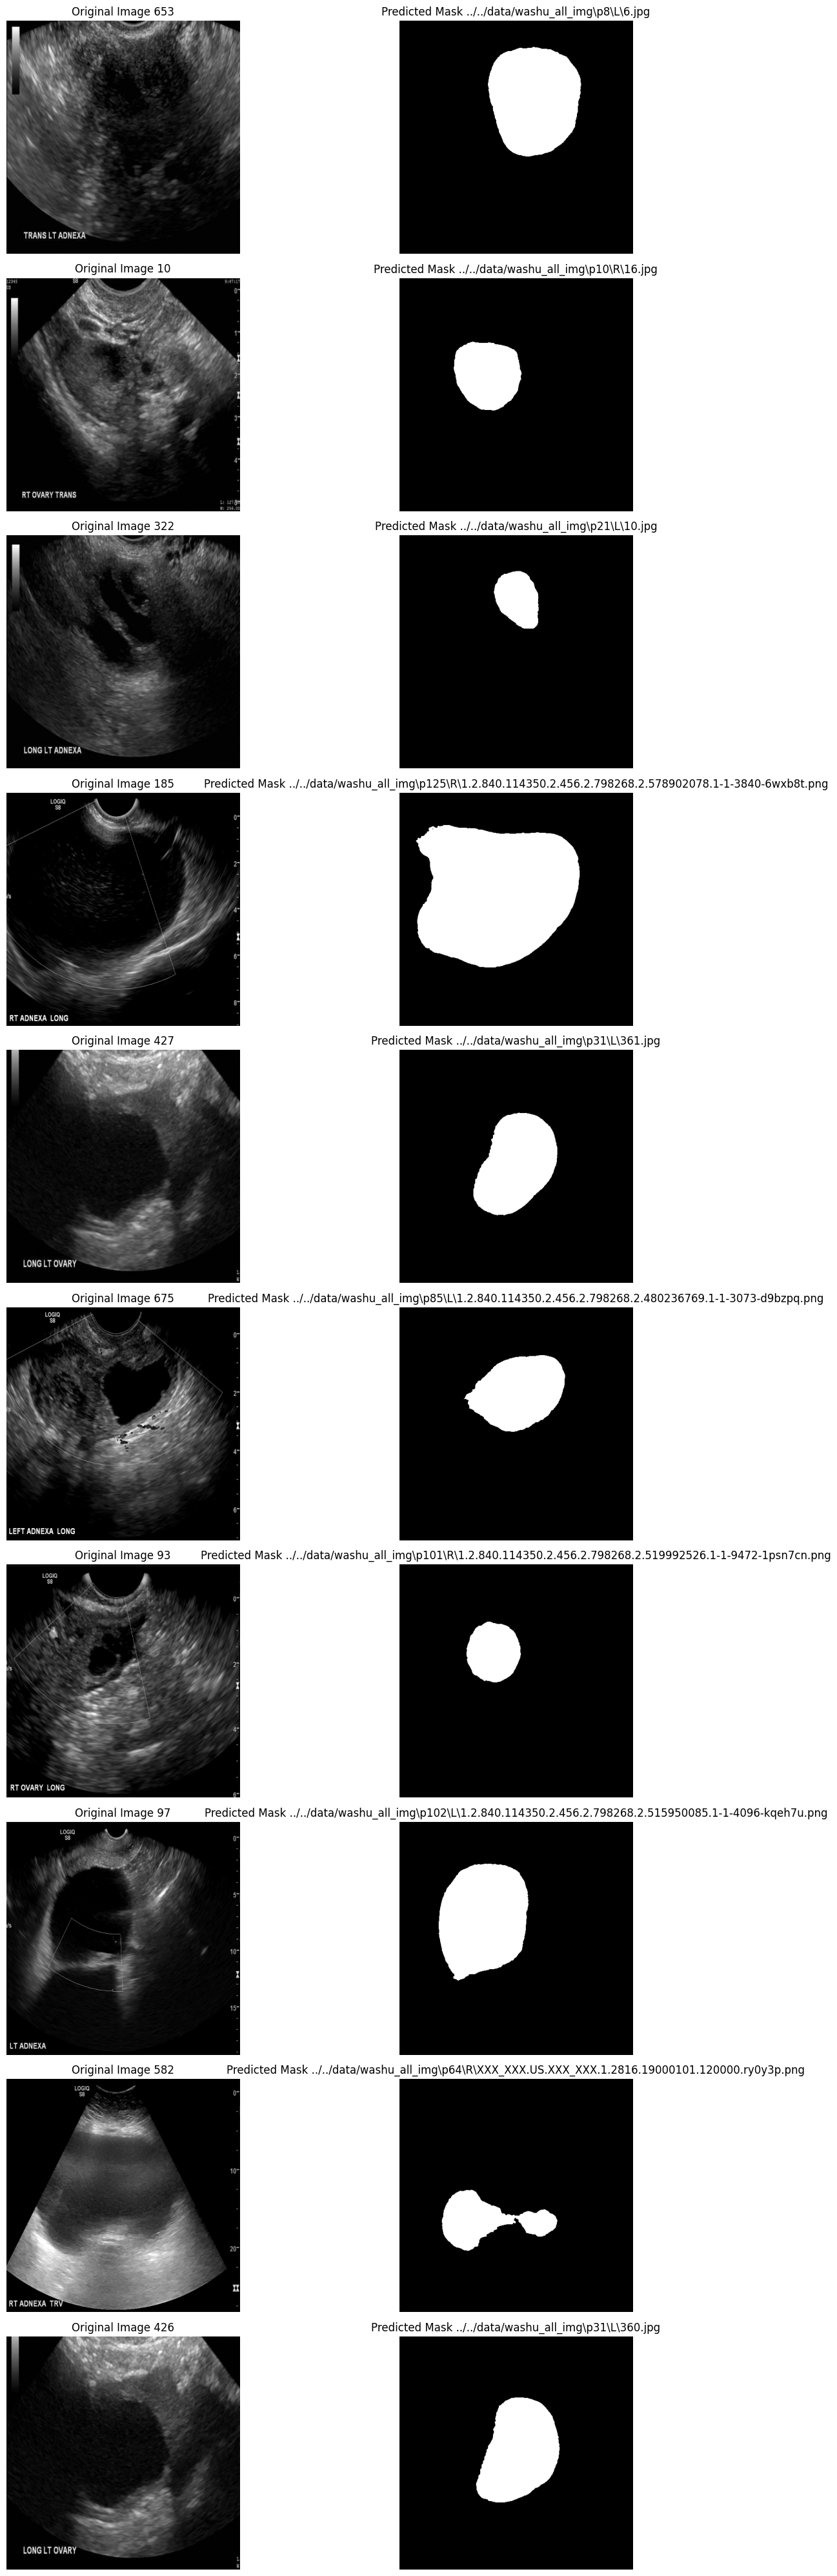

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set the model to evaluation mode
model.eval()

# Randomly select 10 images from the validation dataset
indices = torch.randperm(len(validation_dataset))[:10]

# Create a figure for plotting
fig, axs = plt.subplots(10, 2, figsize=(15, 40))  # 10 rows, 3 columns

with torch.no_grad():
    for i, idx in enumerate(indices):
        # Get the ith sample
        image, true_mask, image_path = validation_dataset[idx]

        # Add batch dimension and transfer to the same device as model
        image_batch = image.unsqueeze(0).to(device)

        # Get model prediction
        prediction = model(image_batch)
        predicted_mask = torch.argmax(prediction, dim=1).squeeze(0).cpu()

        # Convert tensors to numpy arrays for plotting
        image_np = image.squeeze().cpu().numpy()
        true_mask_np = true_mask.squeeze().cpu().numpy()
        predicted_mask_np = predicted_mask.numpy()

        # Plot original image
        axs[i, 0].imshow(image_np, cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f'Original Image {idx}')

        # # Plot true mask
        # axs[i, 1].imshow(true_mask_np, cmap='gray')
        # axs[i, 1].axis('off')
        # axs[i, 1].set_title(f'True Mask {idx}')

        # Plot predicted mask
        axs[i, 1].imshow(predicted_mask_np, cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title(f'Predicted Mask {image_path.replace("Ovarian_Data_iq_process", "Ovarian_Data_iq_process/Masks")}')

plt.tight_layout()
plt.show()